<a href="https://colab.research.google.com/github/madeline-mapes/Regional-Food-Demand-Impact-Analysis/blob/main/Impact_Analysis_ARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries


## Pip Installing

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00


In [ ]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 7.4 MB/s eta 0:00:00


## Libraries

In [ ]:
# import
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from pmdarima import auto_arima
import os
from arch import arch_model
import pandas as pd
import glob
import numpy as np
from google.colab import files
from statsmodels.tsa.stattools import arma_order_select_ic
import time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
from scipy.stats import norm
from statsmodels.formula.api import ols
import statsmodels.api as sm


# Importing Data

Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading all of the datasets in the directory and storing them in the 'dataframes' dictionary

In [ ]:
# Path to your shared drive folder
#folder_path = '/content/drive/Shared drives/MSBA 503/Sprints 5-8/Krusty Krab Consulting/02 Internal /Secret Sauce/'
folder_path = '/content/drive/Shared drives/SD Food Bank Analysis/Model Dataset Import/'

# List all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Dictionary to hold dataframes
dataframes = {}

# Loop through the files and read each into a pandas DataFrame
for file in csv_files:
    # Extract the base name for the DataFrame's name
    base_name = os.path.basename(file).split('.')[0]
    # Read the CSV file
    df = pd.read_csv(file)
    # Store the DataFrame in the dictionary
    dataframes[base_name] = df

# Now, each DataFrame is stored in the `dataframes` dictionary, keyed by file name

In [ ]:
# Printing out the key names that have the stored associated datasets in the dictionary
for key in dataframes.keys():
    print(key)

acs2021_zip
CALFRESH_MEALS
ZILLOW_RENT
Unemployment_Wide
SDFB_FOOD
FSD_FOOD
BLS_UNEMPLOYMENT
BLS_GASOLINE
BLS_ELECTRICITY
BLS_CPI
Zillow_Rent_Data
Region_info
Need_by_Zip
df_output_z
Encampment_Reports_2019
Encampment_Reports_2021
Encampment_Reports_2020
Encampment_Reports_2022
df_merged
rent_food


Assigning the datasets in the dictionary to a designated pandas df

In [ ]:
df_SDFB = dataframes['SDFB_FOOD']
df_FSD = dataframes['FSD_FOOD']
df_Unemploy_wide = dataframes['Unemployment_Wide']
df_zillow_rent = dataframes['Zillow_Rent_Data']
df_demo = dataframes['acs2021_zip']
df_output_z=dataframes['df_output_z']
df_need = dataframes['Need_by_Zip']
df_encampment_2019 = dataframes['Encampment_Reports_2019']
df_encampment_2020 = dataframes['Encampment_Reports_2020']
df_encampment_2021 = dataframes['Encampment_Reports_2021']
df_encampment_2022 = dataframes['Encampment_Reports_2022']
df_unemployment = dataframes['BLS_UNEMPLOYMENT']
df_gas = dataframes['BLS_GASOLINE']
df_electricity = dataframes['BLS_ELECTRICITY']
df_cpi = dataframes['BLS_CPI']
df_region = dataframes['Region_info']
rent_food = dataframes['rent_food']
df_merged = dataframes['df_merged']

# Data Cleaning

## Food Bank Data

Un-pivoting the data

In [ ]:
# SDFB
SDFB_Unpivoted = pd.melt(df_SDFB, id_vars=['Date'], var_name='Zip Code', value_name='Value')
SDFB_Unpivoted.rename(columns={'Value': 'SDFB'}, inplace=True)
SDFB_Unpivoted.rename(columns={'Zip Code': 'ZipCode'}, inplace=True)

# FSD
FSD_Unpivoted = pd.melt(df_FSD, id_vars=['Date'], var_name='Zip Code', value_name='Value')
FSD_Unpivoted.rename(columns={'Value': 'FSD'}, inplace=True)
FSD_Unpivoted.rename(columns={'Zip Code': 'ZipCode'}, inplace=True)

Merging the two food bank data sources

In [ ]:
FSD_SDFB = pd.merge(FSD_Unpivoted, SDFB_Unpivoted, on = ['Date', 'ZipCode'])
FSD_SDFB.head(5)

Date ZipCode      FSD  SDFB
0  2018-01-01   91901   7884.0   0.0
1  2018-02-01   91901  10558.0   0.0
2  2018-03-01   91901  10642.0   0.0
3  2018-04-01   91901  12192.0   0.0
4  2018-05-01   91901  10370.0   0.0

Creating the overall demand column

In [ ]:
#Make new demand column with average of non-null values

# Replace zeros in 'FSD' with values from 'SDFB'
FSD_SDFB['FSD'] = np.where(FSD_SDFB['FSD'] == 0, FSD_SDFB['SDFB'], FSD_SDFB['FSD'])

# Replace zeros in 'SDFB' with values from 'FSD'
FSD_SDFB['SDFB'] = np.where(FSD_SDFB['SDFB'] == 0, FSD_SDFB['FSD'], FSD_SDFB['SDFB'])

# Calculate the mean of 'FSD' and 'SDFB' for each row
FSD_SDFB['Overall_Demand'] = FSD_SDFB[['FSD', 'SDFB']].mean(axis=1, skipna=True)

# Display the first 5 rows of the resulting DataFrame
print(FSD_SDFB.tail(5))

             Date ZipCode  FSD  SDFB  Overall_Demand
13105  2023-05-01   92199  0.0   0.0             0.0
13106  2023-06-01   92199  0.0   0.0             0.0
13107  2023-07-01   92199  0.0   0.0             0.0
13108  2023-08-01   92199  0.0   0.0             0.0
13109  2023-09-01   92199  0.0   0.0             0.0


Creating dummy variable columns to annotate whether the observation is pre, duing, or post pandemic

Note: pre pandemic does not have a dummy variable column because it is the control. Having coefficients for the other two time periods will make the interpretation easier.

In [ ]:
# Convert date to datetime
FSD_SDFB['Date'] = pd.to_datetime(FSD_SDFB['Date'])

# Define the pandemic periods
start_pandemic = pd.Timestamp('2020-04-01')
end_pandemic = pd.Timestamp('2021-08-31')

# Create new columns for dummy variables
# 'During' the pandemic is from April 2020 to August 2021 (inclusive)
FSD_SDFB['During_Pandemic'] = ((FSD_SDFB['Date'] >= start_pandemic) & (FSD_SDFB['Date'] <= end_pandemic)).astype(int)

# 'After' the pandemic is from September 2021 onwards
FSD_SDFB['After_Pandemic'] = (FSD_SDFB['Date'] > end_pandemic).astype(int)

FSD_SDFB.head()

Date ZipCode      FSD     SDFB  Overall_Demand  During_Pandemic  \
0 2018-01-01   91901   7884.0   7884.0          7884.0                0   
1 2018-02-01   91901  10558.0  10558.0         10558.0                0   
2 2018-03-01   91901  10642.0  10642.0         10642.0                0   
3 2018-04-01   91901  12192.0  12192.0         12192.0                0   
4 2018-05-01   91901  10370.0  10370.0         10370.0                0   

   After_Pandemic  
0               0  
1               0  
2               0  
3               0  
4               0

Creating a categorical variable for the time period

In [ ]:
# Assuming 'FSD_SDFB' is your DataFrame
# Replace 'FSD_SDFB' with the actual name of your DataFrame
FSD_SDFB['Date'] = pd.to_datetime(FSD_SDFB['Date'])  # Convert 'Date' column to datetime if not already

def categorize_time_period(date):
    if date < pd.to_datetime('2020-04-01'):
        return 'Pre'  # Before April 2020
    elif pd.to_datetime('2020-04-01') <= date < pd.to_datetime('2021-08-01'):
        return 'During'  # Between April 2020 and August 2021
    else:
        return 'Post'  # After August 2021

# Create a new column 'Time_Period' based on the categorization
FSD_SDFB['Time_Period'] = FSD_SDFB['Date'].apply(categorize_time_period)

# Display the first few rows of the DataFrame with the new column
print(FSD_SDFB.head())

        Date ZipCode      FSD     SDFB  Overall_Demand  During_Pandemic  \
0 2018-01-01   91901   7884.0   7884.0          7884.0                0   
1 2018-02-01   91901  10558.0  10558.0         10558.0                0   
2 2018-03-01   91901  10642.0  10642.0         10642.0                0   
3 2018-04-01   91901  12192.0  12192.0         12192.0                0   
4 2018-05-01   91901  10370.0  10370.0         10370.0                0   

   After_Pandemic Time_Period  
0               0         Pre  
1               0         Pre  
2               0         Pre  
3               0         Pre  
4               0         Pre  


Creating a plot of the count of unique zip codes based on the threshold of minimum observations per time period

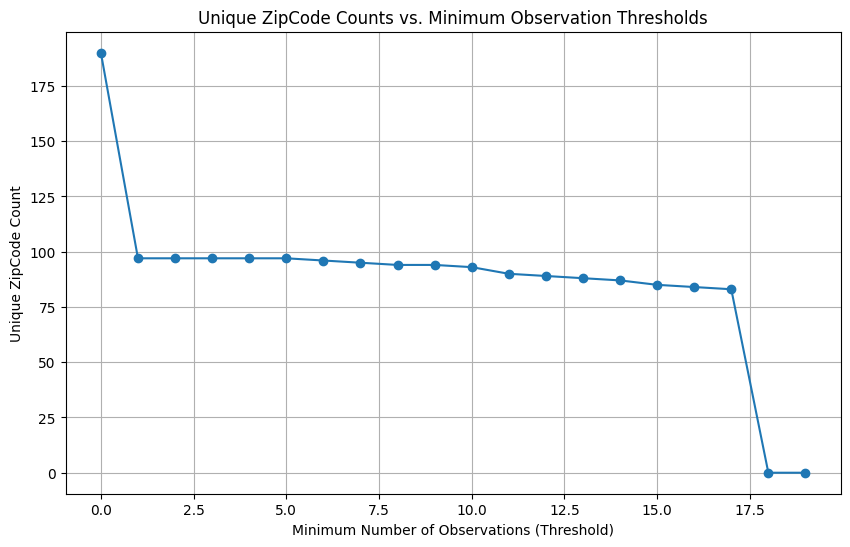

In [ ]:
thresholds = range(0, 20)
unique_zip_counts = []

for min_obs in thresholds:
    # Use the filter function with the current threshold
    filtered_df = FSD_SDFB.groupby('ZipCode').filter(lambda x: (
        (x[x['Overall_Demand'] > 0].shape[0] >= min_obs) and
        (x[(x['During_Pandemic'] == 1) & (x['Overall_Demand'] > 0)].shape[0] >= min_obs) and
        (x[(x['After_Pandemic'] == 1) & (x['Overall_Demand'] > 0)].shape[0] >= min_obs)
    ))
    unique_zip_counts.append(filtered_df['ZipCode'].nunique())

plt.figure(figsize=(10, 6))
plt.plot(thresholds, unique_zip_counts, marker='o')
plt.title('Unique ZipCode Counts vs. Minimum Observation Thresholds')
plt.xlabel('Minimum Number of Observations (Threshold)')
plt.ylabel('Unique ZipCode Count')
plt.grid(True)
plt.show()

Filtering the dataset down to only the zip codes that have at least (10) observations in each time period

In [ ]:
# Define the minimum number of observations
min_observations = 10  # Update this value as needed

# Function to filter ZipCodes based on criteria
def filter_zipcodes(group):
    # Check for minimum observations in each period
    if (group[group['Overall_Demand'] > 0].shape[0] < min_observations or
        group[(group['During_Pandemic'] == 1) & (group['Overall_Demand'] > 0)].shape[0] < min_observations or
        group[(group['After_Pandemic'] == 1) & (group['Overall_Demand'] > 0)].shape[0] < min_observations):
        return False
    return True

# Apply the filter function
filtered_FSD_SDFB = FSD_SDFB.groupby('ZipCode').filter(filter_zipcodes)
unique_zip_code_count = filtered_FSD_SDFB['ZipCode'].nunique()
print(unique_zip_code_count)

93


Cleaning up and renaming the dataset to df_food

In [ ]:
# Selecting only the specified columns and renaming 'Overall_Demand' to 'Food_Demand'
filtered_FSD_SDFB_mod = filtered_FSD_SDFB[['Date', 'ZipCode', 'During_Pandemic', 'After_Pandemic', 'Overall_Demand']].copy()
filtered_FSD_SDFB_mod.rename(columns={'Overall_Demand': 'Food_Demand'}, inplace=True)
df_food = filtered_FSD_SDFB_mod

df_food.head()

Date ZipCode  During_Pandemic  After_Pandemic  Food_Demand
0 2018-01-01   91901                0               0       7884.0
1 2018-02-01   91901                0               0      10558.0
2 2018-03-01   91901                0               0      10642.0
3 2018-04-01   91901                0               0      12192.0
4 2018-05-01   91901                0               0      10370.0

In [ ]:
# create new df for average food demand pre, post, and during covid
df_food_pre = df_food[(df_food['During_Pandemic'] == 0) & (df_food['After_Pandemic'] == 0)]
df_food_during = df_food[df_food['During_Pandemic'] == 1]
df_food_after = df_food[df_food['After_Pandemic'] == 1]

# pre pandemic average demand
df_food_pre = df_food_pre.groupby(['ZipCode']).mean().reset_index()
df_food_pre = df_food_pre.drop(columns=['During_Pandemic', 'After_Pandemic'])
df_food_pre['Avg Demand (Pre)'] = df_food_pre['Food_Demand']

# during pandemic average demand
df_food_during = df_food_during.groupby(['ZipCode']).mean().reset_index()
df_food_during = df_food_during.drop(columns=['During_Pandemic', 'After_Pandemic'])
df_food_during['Avg Demand (During)'] = df_food_during['Food_Demand']

# post pandemic average demand
df_food_after = df_food_after.groupby(['ZipCode']).mean().reset_index()
df_food_after = df_food_after.drop(columns=['During_Pandemic', 'After_Pandemic'])
df_food_after['Avg Demand (After)'] = df_food_after['Food_Demand']
df_food_after = df_food_after.drop(columns=['Food_Demand'])


df_food_after.head()

ZipCode                Date  Avg Demand (After)
0   91901 2022-08-31 13:26:24        24981.658310
1   91905 2022-08-31 13:26:24         8156.322160
2   91906 2022-08-31 13:26:24        11204.714060
3   91908 2022-08-31 13:26:24         4298.880000
4   91910 2022-08-31 13:26:24       155427.074862

In [ ]:
# Save DataFrame to CSV file
#df_food.to_csv('df_food.csv', index=False)

#files.download('df_food.csv')

## Unemployment Data

Converting the date values to actual date values

In [ ]:
# Function to convert date format
def convert_date(date_str):
    if date_str != 'Pre-Covid':
        return datetime.strptime(date_str, '%B-%y').strftime('%m-01-%Y')
    return date_str

# Apply the function to the 'Date' column
df_Unemploy_wide['Date'] = df_Unemploy_wide['Date'].apply(convert_date)

Removing the County average and unpivoting the dataset so that the zip codes are in a single column

In [ ]:
# Remove the 'County (EDD Estimates)' column
df_Unemploy_wide.drop('County (EDD Estimates)', axis=1, inplace=True)

# Unpivot the DataFrame
df_Unemploy_wide = pd.melt(df_Unemploy_wide, id_vars=['Date'], var_name='Zip_Location', value_name='Value')

# Extract only the ZIP code
df_Unemploy_wide['Zip_Code'] = df_Unemploy_wide['Zip_Location'].str.extract(r'(\d+)')

# Drop the original Zip_Location column
df_Unemploy_wide.drop('Zip_Location', axis=1, inplace=True)

# Reordering the columns for better readability
df_Unemploy_wide = df_Unemploy_wide[['Date', 'Zip_Code', 'Value']]

Averaging unemployment for each time period for each zipcode

In [ ]:
# Convert 'Date' column to datetime
df_Unemploy_wide['Date'] = pd.to_datetime(df_Unemploy_wide['Date'], errors='coerce')

# Categorize each date into Pre-Covid, During Covid, or After Covid
def categorize_date(date):
    if date < start_pandemic:
        return 'Pre-Covid'
    elif start_pandemic <= date <= end_pandemic:
        return 'During Covid'
    else:
        return 'After Covid'

df_Unemploy_wide['Period'] = df_Unemploy_wide['Date'].apply(categorize_date)

# Group by ZIP code and Period, then calculate the average
average_values = df_Unemploy_wide.groupby(['Zip_Code', 'Period']).mean().reset_index()

# Pivot the table to get the desired format
df_Unemploy_wide = average_values.pivot(index='Zip_Code', columns='Period', values='Value').reset_index()

# Rename the columns for clarity
df_Unemploy_wide.columns = ['Zip_Code', 'Average_Pre_Covid_Unemployment', 'Average_During_Covid_Unemployment', 'Average_After_Covid_Unemployment']

<ipython-input-22-5ec0d1c1832a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_Unemploy_wide['Date'] = pd.to_datetime(df_Unemploy_wide['Date'], errors='coerce')


In [ ]:
df_Unemploy_wide.head()

Zip_Code  Average_Pre_Covid_Unemployment  Average_During_Covid_Unemployment  \
0    91901                        2.749858                           8.642415   
1    91902                        3.801925                           9.484872   
2    91905                        3.956146                          10.739466   
3    91906                        6.018356                          12.271244   
4    91910                        4.902562                          10.868707   

   Average_After_Covid_Unemployment  
0                          3.534753  
1                          4.674549  
2                          4.696440  
3                          7.112666  
4                          5.833214

## Demographic Data

In [ ]:
df_demo.head()

Year  Zip Code  Population  Veteran Population  White  \
0  2021     91901       18367                1325  15133   
1  2021     91902       17759                1226  10689   
2  2021     91905        1616                  52    817   
3  2021     91906        4547                 221   3071   
4  2021     91910       76291                4487  41200   

   Black or African American  American Indian and Alaska Native  Asian  \
0                        224                                319    539   
1                        409                                 17   2537   
2                         19                                266      3   
3                        123                                294     10   
4                       2954                                466   7499   

   Native Hawaiian and Other Pacific Islander  Other Race  ...  \
0                                          94         759  ...   
1                                         103        1248  ...   
2                                           5          62  ...   
3                                           0         722  ...   
4                                         182        8958  ...   

   Population in Poverty  Population with Disability  \
0                   2237                        1841   
1                   1466                        1889   
2                    509                         318   
3                   1692                         537   
4                  14471                        8690   

   Senior Population (60y+)  Households Receiving SNAP  Median Income  \
0                       NaN                        301         105679   
1                       NaN                        130         112331   
2                       NaN                         85              0   
3                       NaN                        156          49191   
4                   16538.0                       2769          77005   

   Youth Population  Unemployment  Food_Insecurity_Estimate  \
0              4039      2.618557                  0.065963   
1              3129      3.641751                  0.062769   
2               193      3.689738                  0.157117   
3              1502      5.681376                  0.161349   
4             16557      4.792216                  0.100696   

   Food_Insecure_Population  LIHEAP Request  
0               1211.536009          2279.0  
1               1114.705974          2832.0  
2                253.901012           495.0  
3                733.653032           380.0  
4               7682.181917          6036.0  

[5 rows x 24 columns]

In [ ]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Year                                        114 non-null    int64  
 1   Zip Code                                    114 non-null    int64  
 2   Population                                  114 non-null    int64  
 3   Veteran Population                          114 non-null    int64  
 4   White                                       114 non-null    int64  
 5   Black or African American                   114 non-null    int64  
 6   American Indian and Alaska Native           114 non-null    int64  
 7   Asian                                       114 non-null    int64  
 8   Native Hawaiian and Other Pacific Islander  114 non-null    int64  
 9   Other Race                                  114 non-null    int64  
 10  Two or More Ra

In [ ]:
# Remove the 'Year' column from the dataframe
df_demo.drop('Year', axis=1, inplace=True)

# Convert values to percentages of the 'Population' column
# Excluding 'Zip Code' and 'Population' columns from this transformation
percentage_columns = df_demo.columns.drop(['Zip Code', 'Population'])
for column in percentage_columns:
    df_demo[column] = (df_demo[column] / df_demo['Population']) * 100

# Display the first few rows of the transformed dataframe
df_demo.head()


Zip Code  Population  Veteran Population      White  \
0     91901       18367            7.214025  82.392334   
1     91902       17759            6.903542  60.189200   
2     91905        1616            3.217822  50.556931   
3     91906        4547            4.860347  67.539037   
4     91910       76291            5.881428  54.003749   

   Black or African American  American Indian and Alaska Native      Asian  \
0                   1.219579                           1.736811   2.934611   
1                   2.303058                           0.095726  14.285714   
2                   1.175743                          16.460396   0.185644   
3                   2.705080                           6.465802   0.219925   
4                   3.872016                           0.610819   9.829469   

   Native Hawaiian and Other Pacific Islander  Other Race  Two or More Races  \
0                                    0.511787    4.132411           7.072467   
1                                    0.579988    7.027423          15.518892   
2                                    0.309406    3.836634          27.475248   
3                                    0.000000   15.878601           7.191555   
4                                    0.238560   11.741883          19.703504   

   ...  Population in Poverty  Population with Disability  \
0  ...              12.179452                   10.023412   
1  ...               8.254969                   10.636860   
2  ...              31.497525                   19.678218   
3  ...              37.211348                   11.809985   
4  ...              18.968161                   11.390597   

   Senior Population (60y+)  Households Receiving SNAP  Median Income  \
0                       NaN                   1.638809     575.374313   
1                       NaN                   0.732023     632.529985   
2                       NaN                   5.259901       0.000000   
3                       NaN                   3.430834    1081.834176   
4                 21.677524                   3.629524     100.935890   

   Youth Population  Unemployment  Food_Insecurity_Estimate  \
0         21.990526      0.014257                  0.000359   
1         17.619235      0.020507                  0.000353   
2         11.943069      0.228325                  0.009723   
3         33.032769      0.124948                  0.003548   
4         21.702429      0.006281                  0.000132   

   Food_Insecure_Population  LIHEAP Request  
0                  6.596265       12.408123  
1                  6.276851       15.946844  
2                 15.711696       30.631188  
3                 16.134881        8.357159  
4                 10.069578        7.911811  

[5 rows x 23 columns]

## Zillow Rent Data

In [ ]:
df_zillow_rent.head()

RegionName    1/31/2015    2/28/2015    3/31/2015    4/30/2015   5/31/2015  \
0       91911          NaN          NaN          NaN          NaN         NaN   
1       92154          NaN          NaN          NaN          NaN         NaN   
2       91910          NaN          NaN          NaN          NaN         NaN   
3       92126  1644.376224  1684.630705  1695.835918  1700.970388  1692.95254   
4       92105          NaN          NaN          NaN          NaN         NaN   

     6/30/2015    7/31/2015    8/31/2015    9/30/2015  ...    1/31/2023  \
0          NaN          NaN          NaN          NaN  ...  2843.108798   
1          NaN          NaN          NaN          NaN  ...  2827.340974   
2          NaN          NaN          NaN          NaN  ...  2554.895387   
3  1705.078563  1724.669374  1729.273954  1734.808012  ...  2775.411649   
4          NaN          NaN          NaN          NaN  ...  1970.931431   

     2/28/2023    3/31/2023    4/30/2023    5/31/2023    6/30/2023  \
0  2816.116357  2818.291320  2863.494999  2891.297605  2925.455617   
1  2878.039886  2917.589055  2953.193920  3034.018457  3030.417182   
2  2507.731686  2523.797012  2514.150288  2546.453299  2498.583544   
3  2800.492840  2824.229763  2886.189425  2930.633377  2965.726577   
4  1991.034111  2018.616976  2031.039725  2049.061227  2026.300158   

     7/31/2023    8/31/2023    9/30/2023   10/31/2023  
0  2893.212804  2907.381775  2902.111895  2884.194444  
1  3060.997794  3032.081821  3063.160325  3070.536752  
2  2491.216654  2517.308631  2595.789867  2647.778999  
3  2973.186193  2979.626035  2989.215528  2966.322222  
4  2060.998994  2045.722334  2085.141947  2079.212302  

[5 rows x 107 columns]

In [ ]:
# unpivot data
zillow_rent_Unpivoted = pd.melt(df_zillow_rent, id_vars=['RegionName'], var_name='Date', value_name='Value')

# rename columns
zillow_rent_Unpivoted.rename(columns={'Value': 'Average Rent'}, inplace=True)
zillow_rent_Unpivoted.rename(columns={'RegionName': 'ZipCode'}, inplace=True)

# convert 'Date' to datetime
zillow_rent_Unpivoted['Date'] = pd.to_datetime(zillow_rent_Unpivoted['Date'], errors='coerce')

# sort by 'ZipCode' and then by 'Date'
zillow_rent_Unpivoted = zillow_rent_Unpivoted.sort_values(by=['ZipCode', 'Date'])

# reorder columns
zillow_rent_Unpivoted = zillow_rent_Unpivoted[['Date', 'ZipCode', 'Average Rent']]

# filter df to remove values prior to January 2018 (match other datasets)
zillow_rent = zillow_rent_Unpivoted[zillow_rent_Unpivoted['Date'] >= pd.to_datetime('2018-01-31')]

# reset index
zillow_rent.reset_index(drop = True, inplace = True)
zillow_rent.head()

Date  ZipCode  Average Rent
0 2018-01-31    91902           NaN
1 2018-02-28    91902           NaN
2 2018-03-31    91902           NaN
3 2018-04-30    91902           NaN
4 2018-05-31    91902           NaN

In [ ]:
# Create new columns for dummy variables
# 'During' the pandemic is from April 2020 to August 2021 (inclusive)
zillow_rent['During_Pandemic'] = ((zillow_rent['Date'] >= start_pandemic) & (zillow_rent['Date'] <= end_pandemic)).astype(int)

# 'After' the pandemic is from September 2021 onwards
zillow_rent['After_Pandemic'] = (zillow_rent['Date'] > end_pandemic).astype(int)


# Create a new column 'Time_Period' based on the categorization
zillow_rent['Time_Period'] = zillow_rent['Date'].apply(categorize_time_period)

zillow_rent.head()

<ipython-input-29-bf7c09f0ed16>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zillow_rent['During_Pandemic'] = ((zillow_rent['Date'] >= start_pandemic) & (zillow_rent['Date'] <= end_pandemic)).astype(int)
<ipython-input-29-bf7c09f0ed16>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zillow_rent['After_Pandemic'] = (zillow_rent['Date'] > end_pandemic).astype(int)
<ipython-input-29-bf7c09f0ed16>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

Date  ZipCode  Average Rent  During_Pandemic  After_Pandemic  \
0 2018-01-31    91902           NaN                0               0   
1 2018-02-28    91902           NaN                0               0   
2 2018-03-31    91902           NaN                0               0   
3 2018-04-30    91902           NaN                0               0   
4 2018-05-31    91902           NaN                0               0   

  Time_Period  
0         Pre  
1         Pre  
2         Pre  
3         Pre  
4         Pre

In [ ]:
# Group by ZIP code and Period, then calculate the average rent per period
average_rent = zillow_rent.groupby(['ZipCode', 'Time_Period']).mean().reset_index()

# Pivot the table to get the desired format
zillow_average_rent = average_rent.pivot(index='ZipCode', columns='Time_Period', values='Average Rent').reset_index()

# Rename the columns for clarity
zillow_average_rent.columns = ['ZipCode', 'Average_Pre_Covid_Rent', 'Average_During_Covid_Rent', 'Average_After_Covid_Rent']


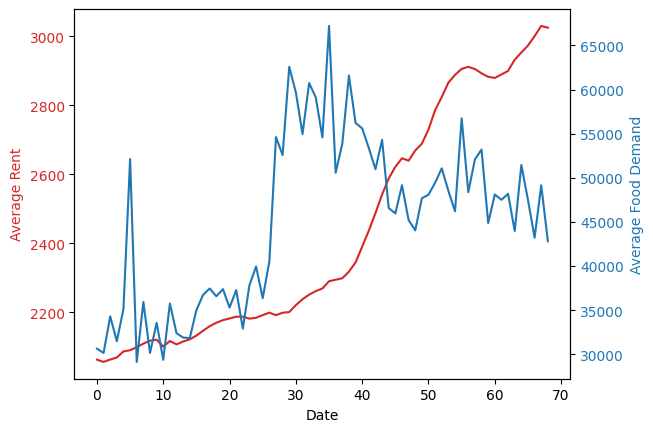

In [ ]:
# Create the first plot
fig, ax1 = plt.subplots()


# Plot 'rent' data
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Rent', color=color)
ax1.plot(rent_food.index, rent_food['Average Rent'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


# Create a second y-axis for the 'food_demand' data
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Food Demand', color=color)
ax2.plot(rent_food.index, rent_food['Food_Demand'], color=color)
ax2.tick_params(axis='y', labelcolor=color)


# Show the plot
plt.show()


In [ ]:
zillow_average_rent

ZipCode  Average_Pre_Covid_Rent  Average_During_Covid_Rent  \
0     91902                     NaN                2843.780107   
1     91910             1887.944092                2421.501530   
2     91911             2090.745231                2708.483368   
3     91913             2359.514982                3005.437327   
4     91914                     NaN                3487.500000   
..      ...                     ...                        ...   
68    92130             3033.683747                3866.770948   
69    92131             2786.703953                3438.787420   
70    92139                     NaN                3824.677473   
71    92154             2203.506174                2792.575299   
72    92173                     NaN                2422.452643   

    Average_After_Covid_Rent  
0                        NaN  
1                1721.868526  
2                1953.199465  
3                2169.674277  
4                        NaN  
..                       ...  
68               2884.040057  
69               2564.715358  
70                       NaN  
71               2049.260393  
72                       NaN  

[73 rows x 4 columns]

## Need by Zip Data

In [ ]:
df_need.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2786 entries, 0 to 2785
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   County             2786 non-null   object 
 1   Neighborhood       1859 non-null   object 
 2   POB                2786 non-null   int64  
 3   Report Month       2786 non-null   object 
 4   Zip                2774 non-null   float64
 5   Number of Records  2786 non-null   int64  
 6   Total Needs        2786 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 152.5+ KB


In [ ]:
df_need['Report Month'].unique()

array(['7/1/2021', '8/1/2021', '9/1/2021', '10/1/2021', '11/1/2021',
       '12/1/2021', '1/1/2022', '2/1/2022', '3/1/2022', '4/1/2022',
       '5/1/2022', '6/1/2022'], dtype=object)

In [ ]:
average_needs_by_zip = df_need.groupby('Zip')['Total Needs'].mean().sort_values()
print(average_needs_by_zip)

Zip
99999.0       1.000000
91302.0       1.000000
91353.0       1.000000
91410.0       1.000000
91710.0       1.000000
              ...     
92020.0    1634.500000
92113.0    1662.166667
91911.0    1686.333333
92105.0    1760.750000
92101.0    2140.750000
Name: Total Needs, Length: 750, dtype: float64


## Converting Beta Coefficients to percentages

In [ ]:
df_output_z.head()

ZipCode  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0    91901  4  1  0                   -1952.000003            -8805.999969   
1    91912  3  1  0                    1749.000044             1060.999951   
2    92165  3  1  2                    7526.061884             4738.974366   
3    92116  1  1  1                    8857.420374             -650.080183   
4    92004  1  1  1                     403.110241             4531.849917   

   During Covid Z-Score  After Covid Z-Score  
0             -0.474061            -0.596837  
1             -0.343071            -0.201953  
2             -0.138602            -0.054758  
3             -0.091481            -0.270432  
4             -0.390706            -0.063048

In [ ]:
# Calculate the average food demand before COVID for each zip code
before_covid = df_food[(df_food['During_Pandemic'] == 0) & (df_food['After_Pandemic'] == 0)]
average_demand_before_covid = before_covid.groupby('ZipCode')['Food_Demand'].mean().reset_index()
average_demand_before_covid.columns = ['ZipCode', 'Average_Before_Covid']

df_food['ZipCode'] = df_food['ZipCode'].astype(str)
df_output_z['ZipCode'] = df_output_z['ZipCode'].astype(str)


# Merge the average demand before COVID into the df_output_z DataFrame
df_output_z = pd.merge(df_output_z, average_demand_before_covid, on='ZipCode', how='left')

# Calculate the percentage change in food demand during COVID for each zip code
df_output_z['%_Change_In_Food_Demand_During_Covid'] = (df_output_z['During Covid Beta Coefficient'] / df_output_z['Average_Before_Covid']) * 100

df_output_z['%_Change_In_Food_Demand_After_Covid'] = (df_output_z['After Beta Coefficient'] / df_output_z['Average_Before_Covid']) * 100


# Display the first few rows of the df_output_z DataFrame to verify the calculations
df_output_z.head()

ZipCode  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0   91901  4  1  0                   -1952.000003            -8805.999969   
1   91912  3  1  0                    1749.000044             1060.999951   
2   92165  3  1  2                    7526.061884             4738.974366   
3   92116  1  1  1                    8857.420374             -650.080183   
4   92004  1  1  1                     403.110241             4531.849917   

   During Covid Z-Score  After Covid Z-Score  Average_Before_Covid  \
0             -0.474061            -0.596837           9847.111111   
1             -0.343071            -0.201953           4143.018167   
2             -0.138602            -0.054758           2176.703704   
3             -0.091481            -0.270432          32549.051667   
4             -0.390706            -0.063048           9610.054537   

   %_Change_In_Food_Demand_During_Covid  %_Change_In_Food_Demand_After_Covid  
0                            -19.823073                           -89.427243  
1                             42.215602                            25.609348  
2                            345.755000                           217.713341  
3                             27.212530                            -1.997232  
4                              4.194672                            47.157380

In [ ]:
# Remove the specified ZIP codes
df_output_z = df_output_z[~df_output_z['ZipCode'].isin(['92009', '92130'])]

In [ ]:
# Rename columns to remove '%' symbol
df_output_z.rename(columns={
    '%_Change_In_Food_Demand_During_Covid': 'Change_In_Food_Demand_During_Covid',
    '%_Change_In_Food_Demand_After_Covid': 'Change_In_Food_Demand_After_Covid'
}, inplace=True)

In [ ]:
# create df for later use in demographic analysis (to avoid name duplication)
df_output_z_demo = df_output_z.copy()

df_output_z_demo.head()

ZipCode  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0   91901  4  1  0                   -1952.000003            -8805.999969   
1   91912  3  1  0                    1749.000044             1060.999951   
2   92165  3  1  2                    7526.061884             4738.974366   
3   92116  1  1  1                    8857.420374             -650.080183   
4   92004  1  1  1                     403.110241             4531.849917   

   During Covid Z-Score  After Covid Z-Score  Average_Before_Covid  \
0             -0.474061            -0.596837           9847.111111   
1             -0.343071            -0.201953           4143.018167   
2             -0.138602            -0.054758           2176.703704   
3             -0.091481            -0.270432          32549.051667   
4             -0.390706            -0.063048           9610.054537   

   Change_In_Food_Demand_During_Covid  Change_In_Food_Demand_After_Covid  
0                          -19.823073                         -89.427243  
1                           42.215602                          25.609348  
2                          345.755000                         217.713341  
3                           27.212530                          -1.997232  
4                            4.194672                          47.157380

In [ ]:
df_output_z.head()

ZipCode  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0   91901  4  1  0                   -1952.000003            -8805.999969   
1   91912  3  1  0                    1749.000044             1060.999951   
2   92165  3  1  2                    7526.061884             4738.974366   
3   92116  1  1  1                    8857.420374             -650.080183   
4   92004  1  1  1                     403.110241             4531.849917   

   During Covid Z-Score  After Covid Z-Score  Average_Before_Covid  \
0             -0.474061            -0.596837           9847.111111   
1             -0.343071            -0.201953           4143.018167   
2             -0.138602            -0.054758           2176.703704   
3             -0.091481            -0.270432          32549.051667   
4             -0.390706            -0.063048           9610.054537   

   Change_In_Food_Demand_During_Covid  Change_In_Food_Demand_After_Covid  
0                          -19.823073                         -89.427243  
1                           42.215602                          25.609348  
2                          345.755000                         217.713341  
3                           27.212530                          -1.997232  
4                            4.194672                          47.157380

# ARIMAX Model Building

## Test Model (For Single Zip Code)

Creating a model for a single zip code to evaluate model performance and computational efficiency

In [ ]:
# Set the Zip Code you would like to subset:

ZipCode = '92103'

df_food_subset = df_food[df_food['ZipCode']== ZipCode]
df_food_subset.head()

Date ZipCode  During_Pandemic  After_Pandemic  Food_Demand
7383 2018-01-01   92103                0               0   18683.4405
7384 2018-02-01   92103                0               0   28643.4405
7385 2018-03-01   92103                0               0   39843.9925
7386 2018-04-01   92103                0               0   26472.3850
7387 2018-05-01   92103                0               0   31109.5745

ACF and PACF plot to test for non-stationality

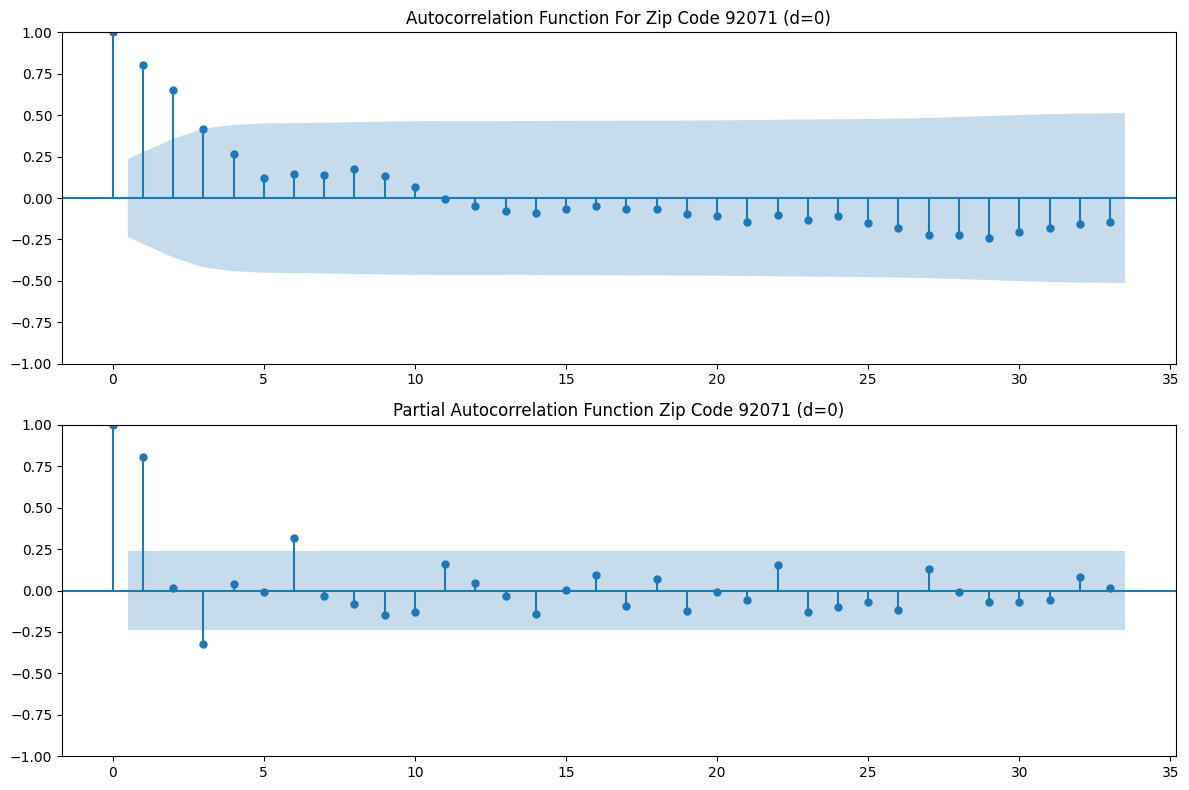

In [ ]:
# Calculate the appropriate number of lags, which is less than half of the sample size
n_obs = df_food_subset.shape[0]
max_lags = n_obs // 2 - 1  # Subtracting 1 for safety

# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the ACF
plot_acf(df_food_subset['Food_Demand'], lags=max_lags, ax=ax1)
ax1.set_title('Autocorrelation Function For Zip Code 92071 (d=0)')

# Plot the PACF
plot_pacf(df_food_subset['Food_Demand'], lags=max_lags, ax=ax2)
ax2.set_title('Partial Autocorrelation Function Zip Code 92071 (d=0)')

plt.tight_layout()
plt.show()

The data is then differenced (d=1) and retested

The following plot should show stationality

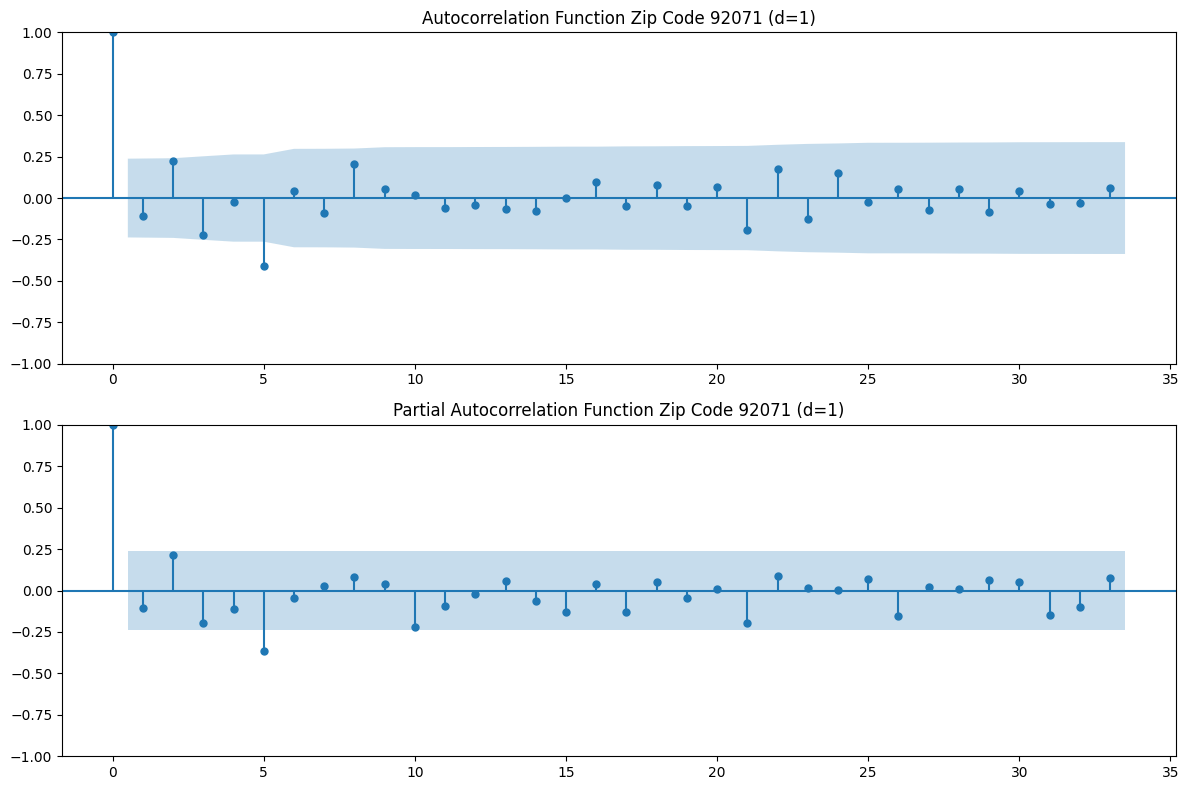

In [ ]:
# Difference the time series data to remove non-stationarity
df_food_subset_d1 = df_food_subset['Food_Demand'].diff().dropna()

# Calculate the appropriate number of lags, which is less than half of the sample size
# Use the length of the differenced time series now
n_obs_diff = df_food_subset_d1.shape[0]
max_lags = n_obs_diff // 2 - 1  # Subtracting 1 for safety

# Plot the ACF and PACF for the differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the ACF
plot_acf(df_food_subset_d1, lags=max_lags, ax=ax1)
ax1.set_title('Autocorrelation Function Zip Code 92071 (d=1)')

# Plot the PACF
plot_pacf(df_food_subset_d1, lags=max_lags, ax=ax2)
ax2.set_title('Partial Autocorrelation Function Zip Code 92071 (d=1)')

plt.tight_layout()
plt.show()

Testing out the ARIMAX model on the subsetted data

<ipython-input-45-946524e2fae1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_food_subset['Date'] = pd.to_datetime(df_food_subset['Date'])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, 

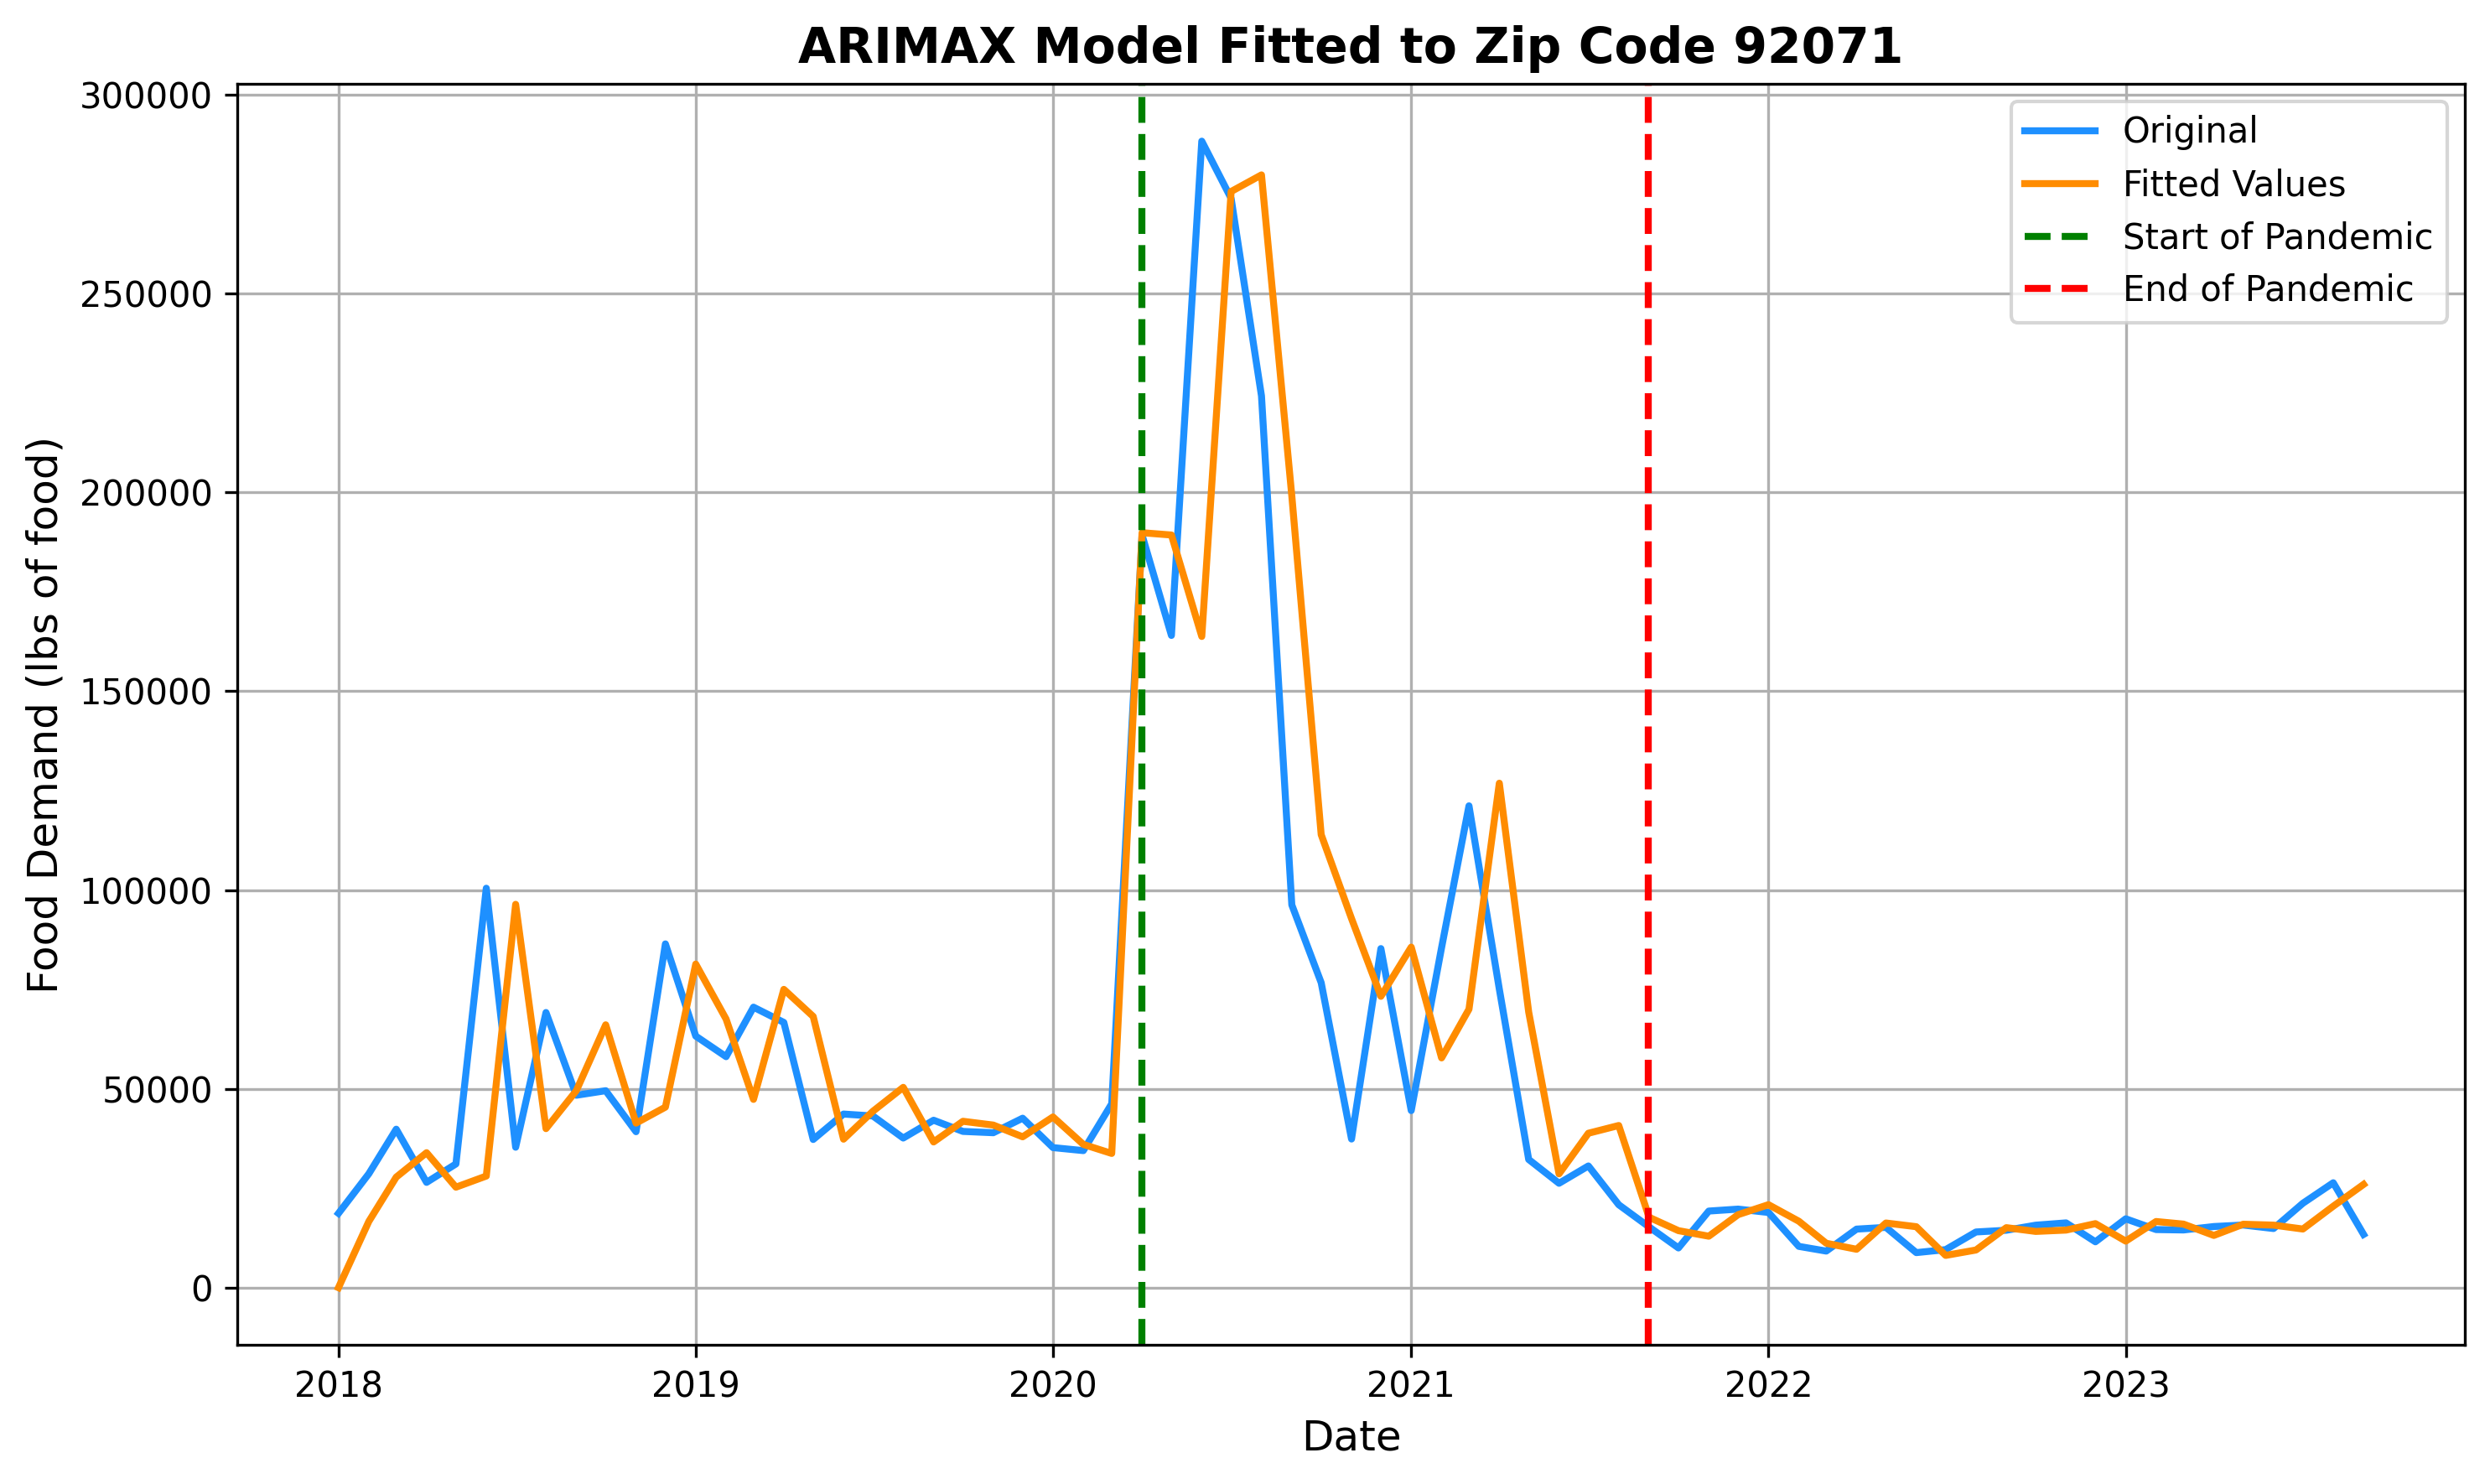

Time taken to run the model: 1.11 seconds
Best ARIMA(p, d, q) parameters: (3, 1, 0)
Beta Coefficients - During Pandemic: 143003.0345, After Pandemic: 137415.7415


In [ ]:
# Ensure the Date column is a pandas datetime object and set as index
df_food_subset['Date'] = pd.to_datetime(df_food_subset['Date'])
df_food_subset.set_index('Date', inplace=True)

# Prepare the time series (assuming the demand column is named 'Food_Demand')
time_series = df_food_subset['Food_Demand']

# Dummy variables (assuming they are named 'During_Pandemic' and 'After_Pandemic')
X = df_food_subset[['During_Pandemic', 'After_Pandemic']]

# Start the timer
start_time = time.time()

# Estimate the best ARIMA(p, d, q) parameters
best_fit = arma_order_select_ic(time_series, ic=['aic', 'bic'], trend='n')
p, q = best_fit.aic_min_order

# Fit the ARIMAX model
model = ARIMA(time_series, order=(p, 1, q), exog=X)
results = model.fit()

# End the timer and calculate the time taken
end_time = time.time()
time_taken = end_time - start_time

# Extract the beta coefficients
beta_during = results.params['During_Pandemic']
beta_after = results.params['After_Pandemic']

# Pandemic start and end dates
start_pandemic = pd.Timestamp('2020-04-01')
end_pandemic = pd.Timestamp('2021-08-31')

# Plotting the fitted values with higher resolution and a cleaner, more professional look
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df_food_subset.index, time_series, label='Original', color='dodgerblue', linewidth=2)
plt.plot(df_food_subset.index, results.fittedvalues, color='darkorange', linestyle='-', label='Fitted Values', linewidth=2)
plt.axvline(start_pandemic, color='green', linestyle='--', label='Start of Pandemic', linewidth=2)
plt.axvline(end_pandemic, color='red', linestyle='--', label='End of Pandemic', linewidth=2)
plt.title('ARIMAX Model Fitted to Zip Code 92071', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Food Demand (lbs of food)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Output the time taken and the model parameters
print(f'Time taken to run the model: {time_taken:.2f} seconds')
print(f'Best ARIMA(p, d, q) parameters: ({p}, 1, {q})')
print(f'Beta Coefficients - During Pandemic: {beta_during:.4f}, After Pandemic: {beta_after:.4f}')
warnings.filterwarnings('ignore')

## Full Model for all Zip Codes

In [ ]:
# Convert 'Date' to datetime and set as index
df_food['Date'] = pd.to_datetime(df_food['Date'])
df_food.sort_values('Date', inplace=True)

# Suppress warnings to keep the output clean
warnings.filterwarnings('ignore')

# Prepare the output DataFrame
df_output = pd.DataFrame(columns=[
    'ZipCode', 'p', 'd', 'q',
    'During Covid Beta Coefficient',
    'After Beta Coefficient',
    'AIC', 'BIC'
])

# Process each unique zip code
for zip_code in tqdm(df_food['ZipCode'].unique(), desc='Processing Zip Codes'):
    # Filter the DataFrame for the current zip code
    df_zip = df_food[df_food['ZipCode'] == zip_code].set_index('Date')

    # Prepare the time series and the exogenous variables
    time_series = df_zip['Food_Demand']
    X = df_zip[['During_Pandemic', 'After_Pandemic']]

    # Estimate the best ARIMA(p, d, q) parameters
    best_fit = arma_order_select_ic(time_series, ic='aic', trend='n')
    p, q = best_fit.aic_min_order
    d = 1  # Assuming differencing order is 1 based on prior analysis

    # Fit the ARIMAX model
    model = ARIMA(time_series, order=(p, d, q), exog=X)
    results = model.fit()

    # Extract the beta coefficients and goodness-of-fit statistics
    beta_during = results.params.get('During_Pandemic', np.nan)
    beta_after = results.params.get('After_Pandemic', np.nan)
    aic = results.aic
    bic = results.bic

    # Create a new row DataFrame
    new_row = pd.DataFrame([{
        'ZipCode': zip_code,
        'p': p,
        'd': d,
        'q': q,
        'During Covid Beta Coefficient': beta_during,
        'After Beta Coefficient': beta_after,
        'AIC': aic,
        'BIC': bic
    }])

    # Append the new row to the output DataFrame
    df_output = pd.concat([df_output, new_row], ignore_index=True)

Processing Zip Codes:   0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:
df_food.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6417 entries, 0 to 12212
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             6417 non-null   datetime64[ns]
 1   ZipCode          6417 non-null   object        
 2   During_Pandemic  6417 non-null   int64         
 3   After_Pandemic   6417 non-null   int64         
 4   Food_Demand      6417 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 300.8+ KB


In [ ]:
df_output.head()

ZipCode  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0   91901  4  1  0                   -1952.000003            -8805.999969   
1   91912  3  1  0                    1749.000044             1060.999951   
2   92165  3  1  2                    7526.061884             4738.974366   
3   92116  1  1  1                    8857.420374             -650.080183   
4   92004  1  1  1                     403.110241             4531.849917   

           AIC          BIC  
0  1410.088209  1425.624763  
1  1210.362205  1223.679251  
2  1261.376214  1279.132276  
3  1467.240280  1478.337818  
4  1270.293904  1281.391442

Plotting the distribution of beta coefficents

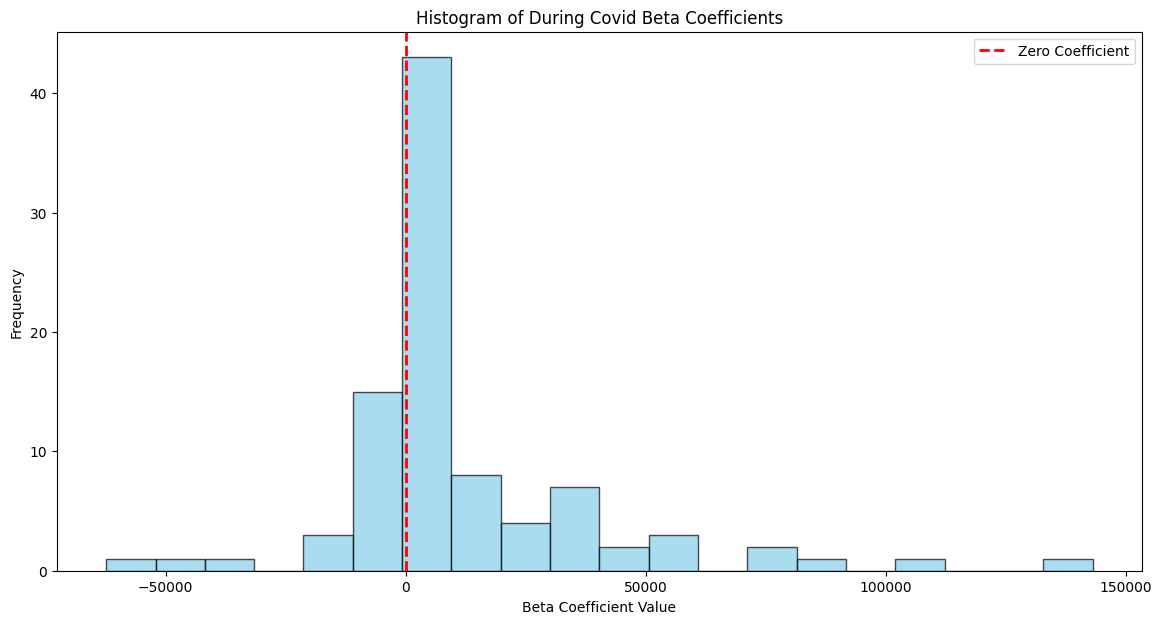

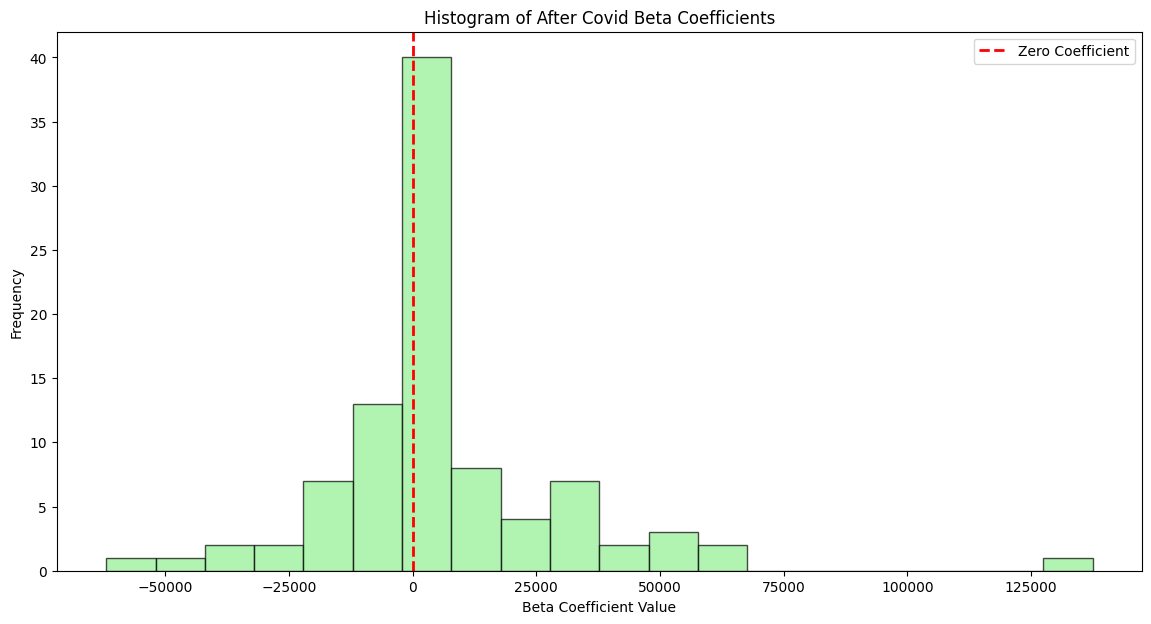

In [ ]:
# Generate a histogram for the 'During Covid Beta Coefficient'
plt.figure(figsize=(14, 7))
plt.hist(df_output['During Covid Beta Coefficient'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Coefficient')
plt.title('Histogram of During Covid Beta Coefficients')
plt.xlabel('Beta Coefficient Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Generate a histogram for the 'After Beta Coefficient'
plt.figure(figsize=(14, 7))
plt.hist(df_output['After Beta Coefficient'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Coefficient')
plt.title('Histogram of After Covid Beta Coefficients')
plt.xlabel('Beta Coefficient Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Creating a Z-Score for each of the beta coeffients to convert to a standard normal distribution

In [ ]:
df_output.head()

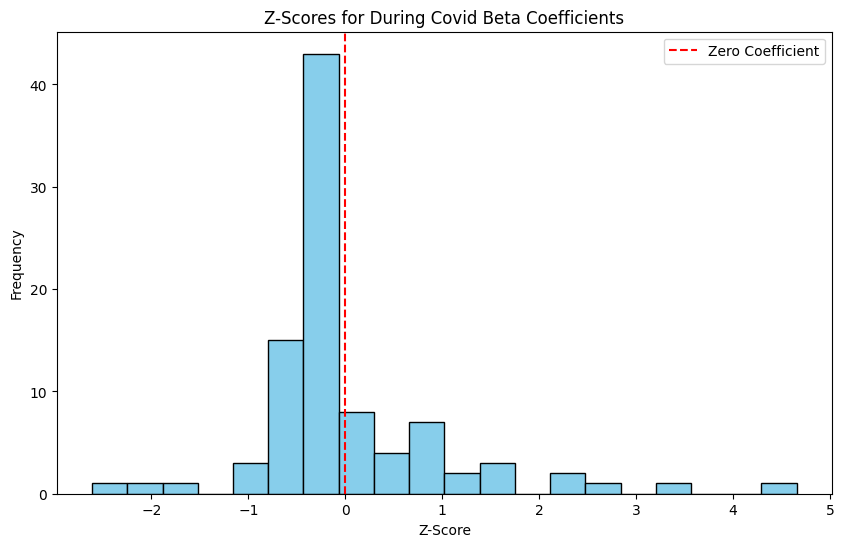

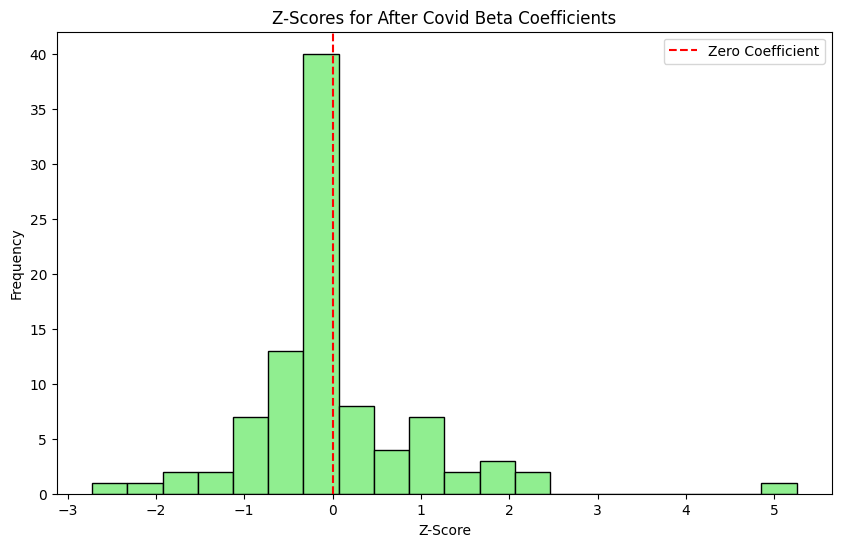

In [ ]:
# Rename the dataframe to df_output_z
df_output_z = df_output.copy()

# Calculate the z-scores for the 'During Covid Beta Coefficient'
df_output_z['During Covid Z-Score'] = (
    df_output['During Covid Beta Coefficient'] - df_output['During Covid Beta Coefficient'].mean()
) / df_output['During Covid Beta Coefficient'].std()

# Calculate the z-scores for the 'After Covid Beta Coefficient'
df_output_z['After Covid Z-Score'] = (
    df_output['After Beta Coefficient'] - df_output['After Beta Coefficient'].mean()
) / df_output['After Beta Coefficient'].std()


# Plotting the histograms for the z-scores
# Histogram for 'During Covid Beta Coefficient'
plt.figure(figsize=(10, 6))
plt.hist(df_output_z['During Covid Z-Score'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Coefficient')
plt.title('Z-Scores for During Covid Beta Coefficients')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Histogram for 'After Covid Beta Coefficient'
plt.figure(figsize=(10, 6))
plt.hist(df_output_z['After Covid Z-Score'], bins=20, color='lightgreen', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Coefficient')
plt.title('Z-Scores for After Covid Beta Coefficients')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

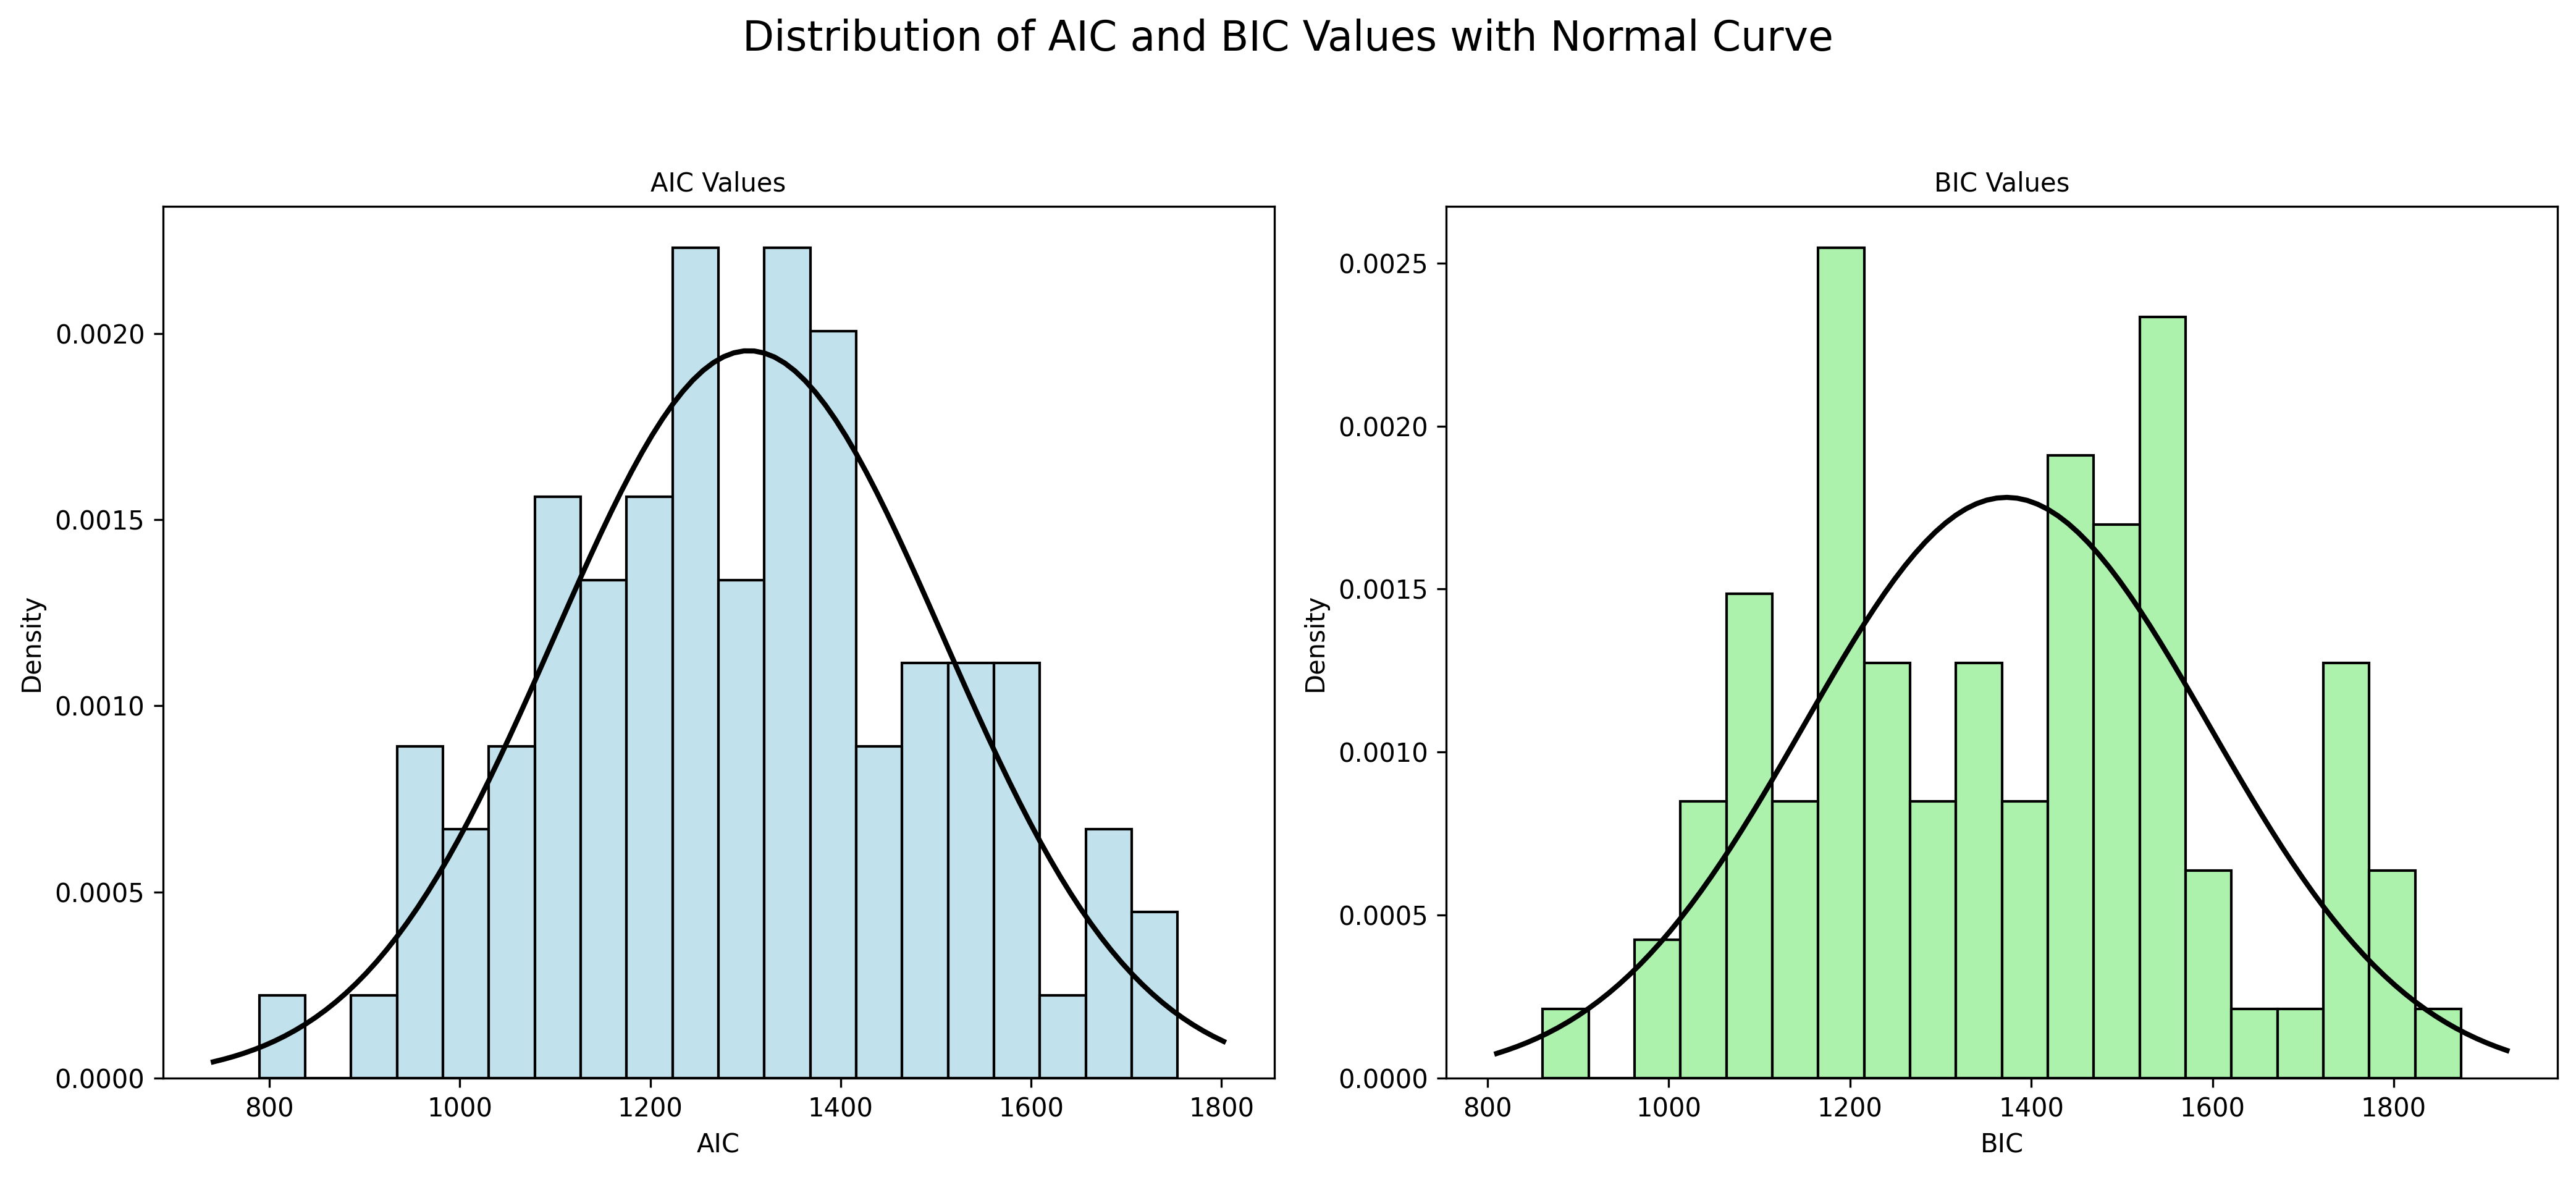

In [ ]:
# Assuming df_output is a given DataFrame with AIC and BIC values
# For demonstration, let's create a mock df_output
np.random.seed(0)
df_output = pd.DataFrame({
    'AIC': np.random.normal(1300, 200, 93),
    'BIC': np.random.normal(1350, 220, 93)
})

aic_values = df_output['AIC']
bic_values = df_output['BIC']

# Calculate mean and standard deviation
aic_mean, aic_std = np.mean(aic_values), np.std(aic_values)
bic_mean, bic_std = np.mean(bic_values), np.std(bic_values)

# Set the resolution of the plot to 300 DPI for higher quality output
plt.figure(figsize=(14, 6), dpi=300)

# AIC Histogram
plt.subplot(1, 2, 1)
sns.histplot(aic_values, bins=20, kde=False, stat='density', color='lightblue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, aic_mean, aic_std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('AIC Values', fontsize=10)

# BIC Histogram
plt.subplot(1, 2, 2)
sns.histplot(bic_values, bins=20, kde=False, stat='density', color='lightgreen')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, bic_mean, bic_std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('BIC Values', fontsize=10)

# Overall title
plt.suptitle('Distribution of AIC and BIC Values with Normal Curve', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

# Analysis

## Rent Regression

In [ ]:
rent_food.head()

Food_Demand  Average Rent
0  30636.333117   2062.353468
1  30154.373867   2055.799526
2  34297.146789   2062.715605
3  31485.062445   2068.614518
4  35148.010797   2086.282059

In [ ]:
df_output_z.head()

ZipCode  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0   91901  4  1  0                   -1952.000003            -8805.999969   
1   91912  3  1  0                    1749.000044             1060.999951   
2   92165  3  1  2                    7526.061884             4738.974366   
3   92116  1  1  1                    8857.420374             -650.080183   
4   92004  1  1  1                     403.110241             4531.849917   

           AIC          BIC  During Covid Z-Score  After Covid Z-Score  
0  1410.088209  1425.624763             -0.474061            -0.596837  
1  1210.362205  1223.679251             -0.343071            -0.201953  
2  1261.376214  1279.132276             -0.138602            -0.054758  
3  1467.240280  1478.337818             -0.091481            -0.270432  
4  1270.293904  1281.391442             -0.390706            -0.063048

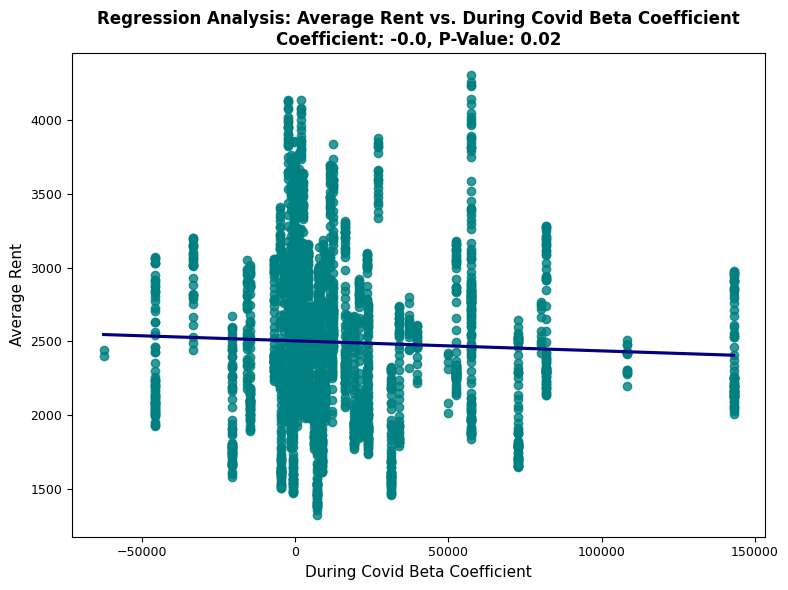

In [ ]:
# Ensure that 'ZipCode' in df_output_z and 'Zip_Code' in df_rent_food are of the same type for merging
df_output_z['ZipCode'] = df_output_z['ZipCode'].astype(str)
zillow_rent['ZipCode'] = zillow_rent['ZipCode'].astype(str)

# Merge the datasets on the Zip Code
merged_data = pd.merge(zillow_rent, df_output_z, on='ZipCode')

# Create the regression model using Average Rent as the dependent variable and During Covid Beta Coefficient as the independent
# Note: You need to wrap the variable names with spaces in Q() for the formula to be parsed correctly.
model = ols('Q("Average Rent") ~ Q("During Covid Beta Coefficient")', data=merged_data).fit()

# Extract the coefficient and p-value, rounded to two decimal places
coeff = model.params['Q("During Covid Beta Coefficient")']
p_val = model.pvalues['Q("During Covid Beta Coefficient")']

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(x='During Covid Beta Coefficient', y='Average Rent', data=merged_data, ci=None, color='teal', line_kws={'color':'navy'})
coeff = round(model.params['Q("During Covid Beta Coefficient")'], 2)  # Corrected reference
p_val = round(model.pvalues['Q("During Covid Beta Coefficient")'], 2)  # Corrected reference
title_text = f'Regression Analysis: Average Rent vs. During Covid Beta Coefficient\nCoefficient: {coeff}, P-Value: {p_val}'
plt.title(title_text, fontsize=12, fontweight='bold')
plt.xlabel('During Covid Beta Coefficient', fontsize=11)
plt.ylabel('Average Rent', fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()


## Unemployment Regression

In [ ]:
df_Unemploy_wide.head()

Zip_Code  Average_Pre_Covid_Unemployment  Average_During_Covid_Unemployment  \
0    91901                        2.749858                           8.642415   
1    91902                        3.801925                           9.484872   
2    91905                        3.956146                          10.739466   
3    91906                        6.018356                          12.271244   
4    91910                        4.902562                          10.868707   

   Average_After_Covid_Unemployment  
0                          3.534753  
1                          4.674549  
2                          4.696440  
3                          7.112666  
4                          5.833214

In [ ]:
df_output_z.head()

ZipCode  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0   91901  4  1  0                   -1952.000003            -8805.999969   
1   91912  3  1  0                    1749.000044             1060.999951   
2   92165  3  1  2                    7526.061884             4738.974366   
3   92116  1  1  1                    8857.420374             -650.080183   
4   92004  1  1  1                     403.110241             4531.849917   

           AIC          BIC  During Covid Z-Score  After Covid Z-Score  
0  1410.088209  1425.624763             -0.474061            -0.596837  
1  1210.362205  1223.679251             -0.343071            -0.201953  
2  1261.376214  1279.132276             -0.138602            -0.054758  
3  1467.240280  1478.337818             -0.091481            -0.270432  
4  1270.293904  1281.391442             -0.390706            -0.063048

In [ ]:
merged_data.head()

Date ZipCode  Average Rent  During_Pandemic  After_Pandemic  \
0 2018-01-31   91910   1646.951341                0               0   
1 2018-02-28   91910   1677.945821                0               0   
2 2018-03-31   91910   1660.307735                0               0   
3 2018-04-30   91910   1669.645202                0               0   
4 2018-05-31   91910   1652.639079                0               0   

  Time_Period  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0         Pre  3  1  2                   72832.326034            58717.312989   
1         Pre  3  1  2                   72832.326034            58717.312989   
2         Pre  3  1  2                   72832.326034            58717.312989   
3         Pre  3  1  2                   72832.326034            58717.312989   
4         Pre  3  1  2                   72832.326034            58717.312989   

           AIC          BIC  During Covid Z-Score  After Covid Z-Score  
0  1581.029255  1598.785317              2.172795             2.105492  
1  1581.029255  1598.785317              2.172795             2.105492  
2  1581.029255  1598.785317              2.172795             2.105492  
3  1581.029255  1598.785317              2.172795             2.105492  
4  1581.029255  1598.785317              2.172795             2.105492

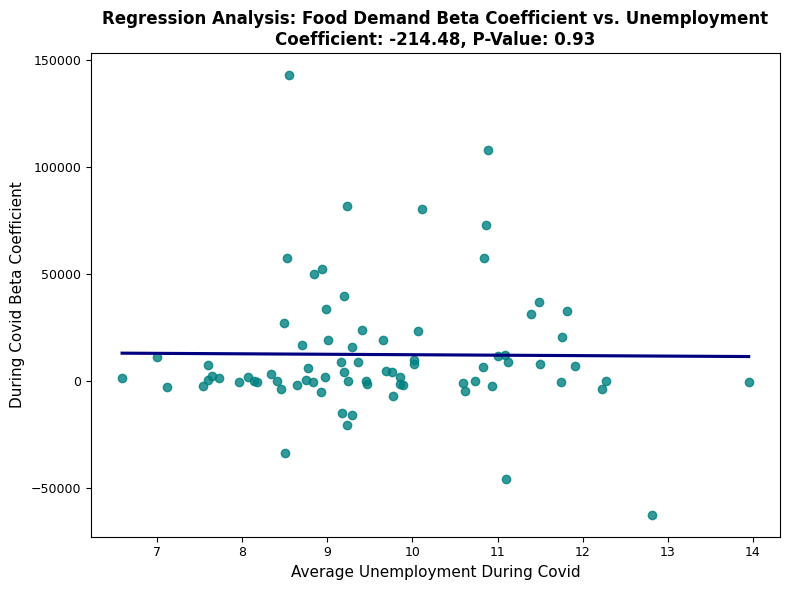

In [ ]:
# Ensure that 'ZipCode' in df_output_z and 'Zip_Code' in df_unemployment_wide are of the same type
df_output_z['ZipCode'] = df_output_z['ZipCode'].astype(str)
df_Unemploy_wide['Zip_Code'] = df_Unemploy_wide['Zip_Code'].astype(str)

# Merge the datasets on the Zip Code
merged_data = pd.merge(df_output_z, df_Unemploy_wide, left_on='ZipCode', right_on='Zip_Code')

# Create the regression model using the correct variable format
model = ols('Q("During Covid Beta Coefficient") ~ Average_During_Covid_Unemployment', data=merged_data).fit()

# Extract the coefficient and p-value, rounded to two decimal places
coeff = model.params['Average_During_Covid_Unemployment']
p_val = model.pvalues['Average_During_Covid_Unemployment']

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(x='Average_During_Covid_Unemployment', y='During Covid Beta Coefficient', data=merged_data, ci=None, color='teal', line_kws={'color':'navy'})
title_text = f'Regression Analysis: Food Demand Beta Coefficient vs. Unemployment\nCoefficient: {coeff:.2f}, P-Value: {p_val:.2f}'
plt.title(title_text, fontsize=12, fontweight='bold')
plt.xlabel('Average Unemployment During Covid', fontsize=11)
plt.ylabel('During Covid Beta Coefficient', fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()


## Food Demand Over Time

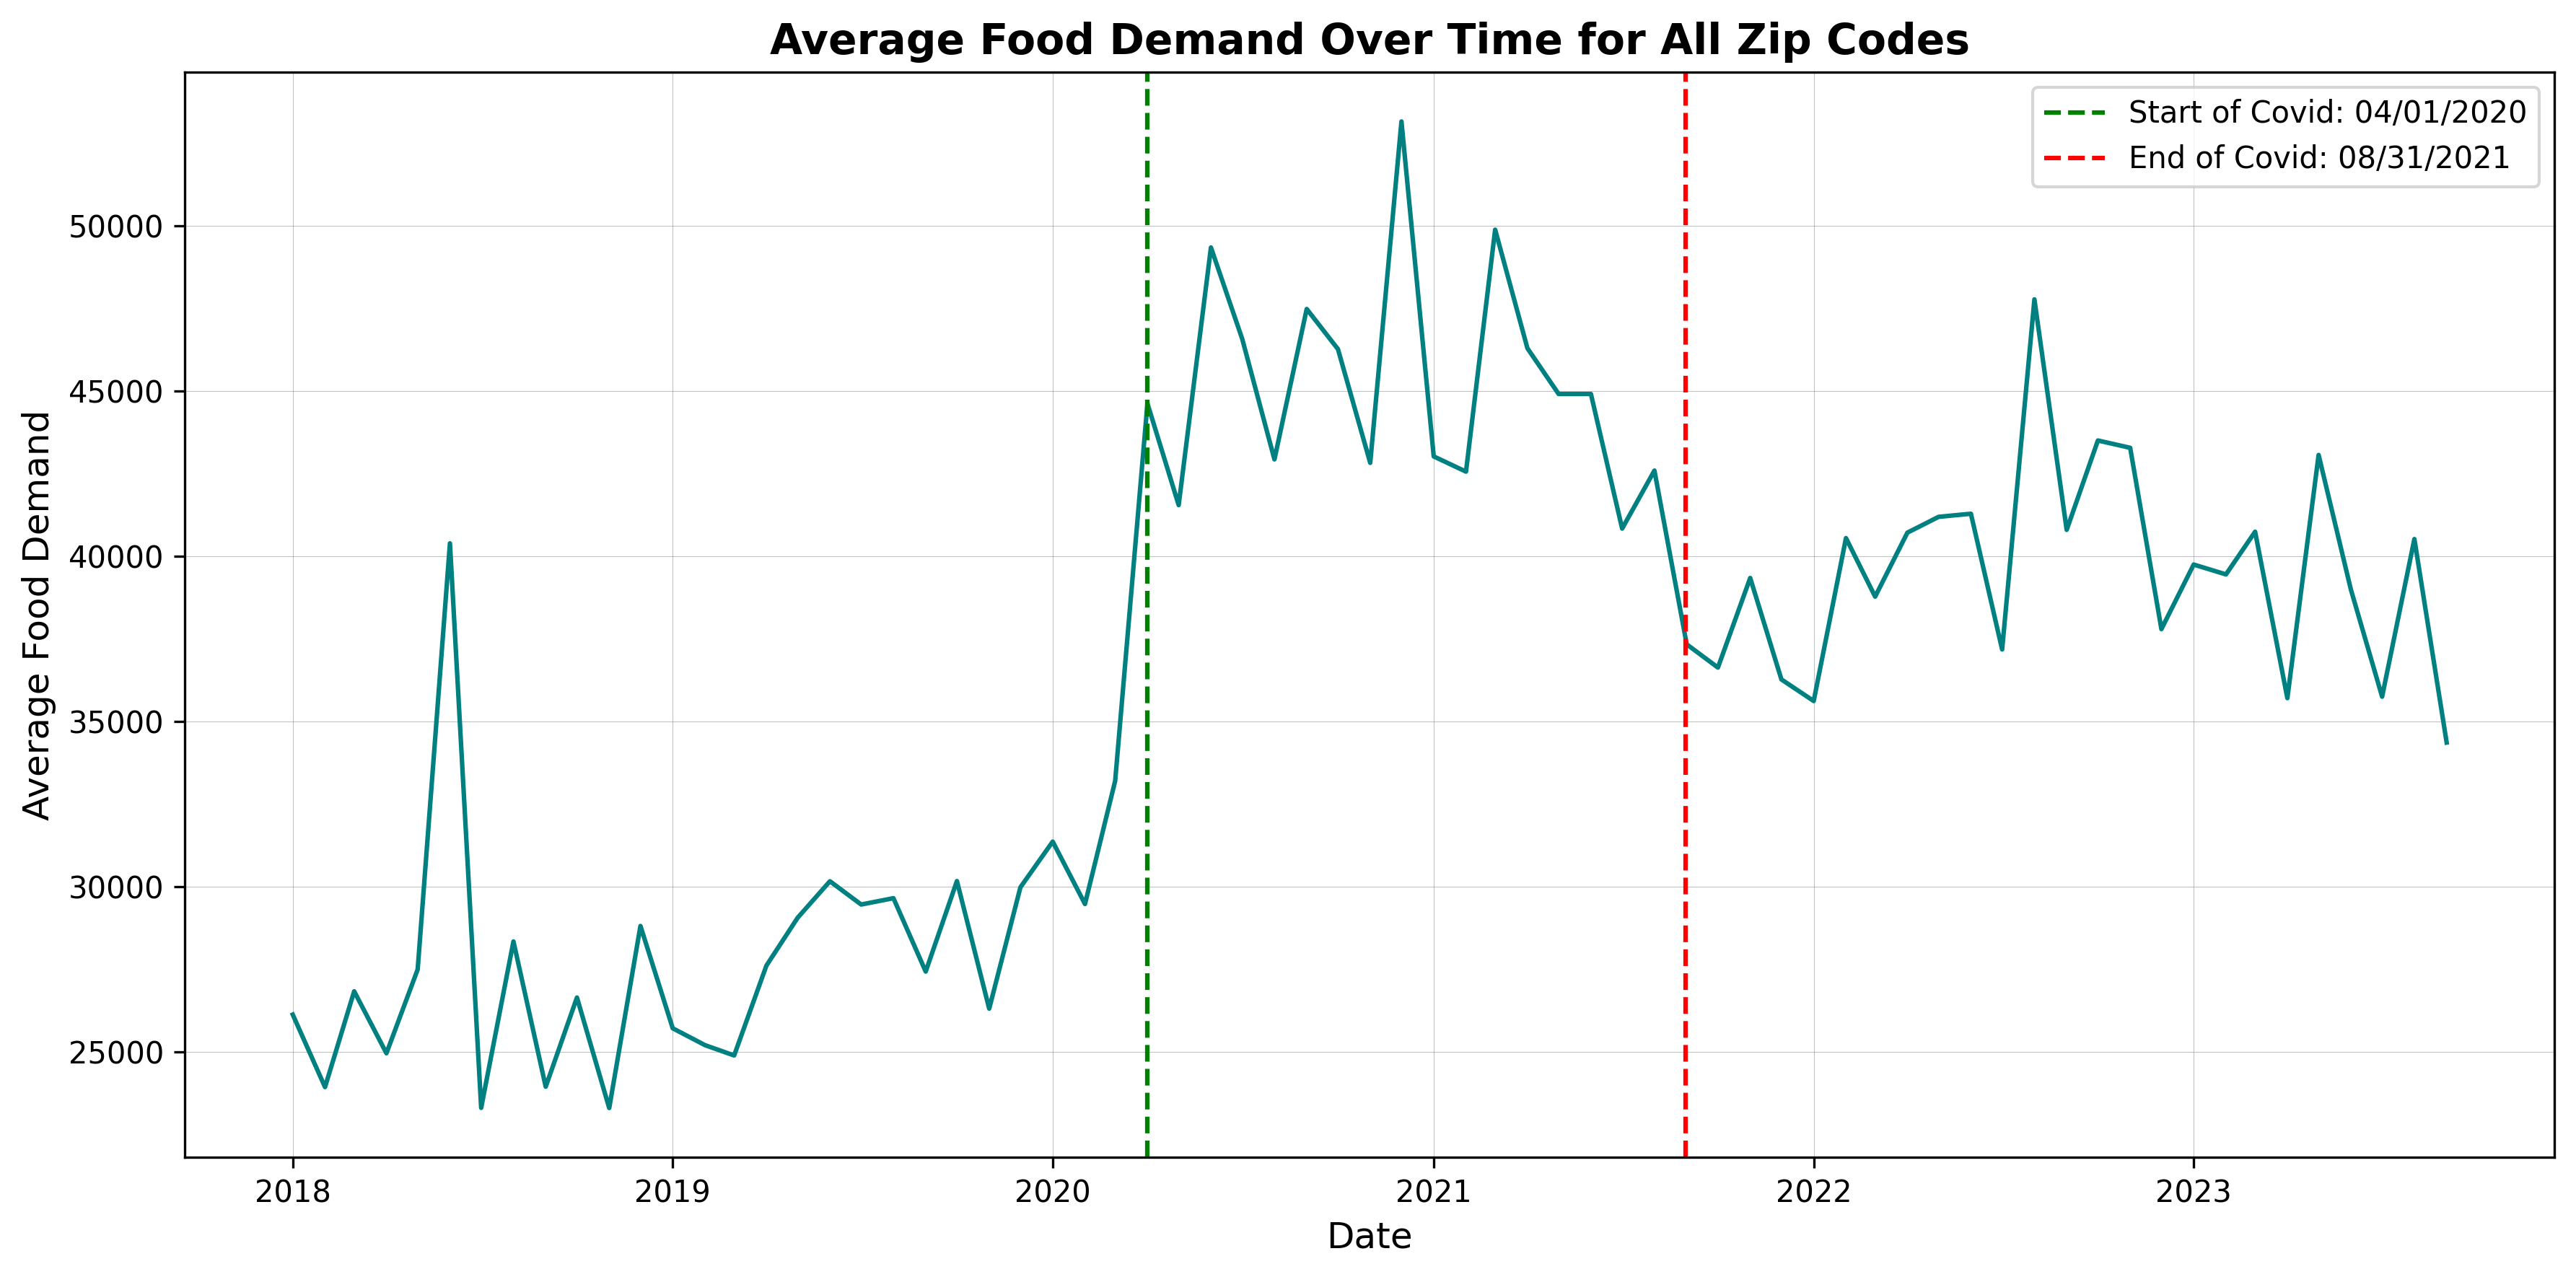

In [ ]:
# Convert 'Date' column to datetime
df_food['Date'] = pd.to_datetime(df_food['Date'])

# Group by Date and calculate the average Food Demand for all zip codes over time
average_demand_over_time = df_food.groupby('Date')['Food_Demand'].mean().reset_index()

# Pandemic start and end dates
start_pandemic = pd.Timestamp('2020-04-01')
end_pandemic = pd.Timestamp('2021-08-31')

# Plotting
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(average_demand_over_time['Date'], average_demand_over_time['Food_Demand'], color='teal')
plt.axvline(start_pandemic, color='green', linestyle='--', label='Start of Covid: 04/01/2020')
plt.axvline(end_pandemic, color='red', linestyle='--', label='End of Covid: 08/31/2021')
plt.title('Average Food Demand Over Time for All Zip Codes', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Food Demand', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.tight_layout()
plt.show()


## Zillow Rent Analysis

In [ ]:
df_food['Date'] = pd.to_datetime(df_food['Date'])
zillow_rent['Date'] = pd.to_datetime(zillow_rent['Date'])

# Extract year and month into a new column
zillow_rent['year_month'] = zillow_rent['Date'].dt.to_period('M')
df_food['year_month'] = df_food['Date'].dt.to_period('M')

# Convert 'zipcode' and 'date' to string in both DataFrames
df_food['ZipCode'] = df_food['ZipCode'].astype(str)
df_food['year_month'] = df_food['year_month'].astype(str)

zillow_rent['ZipCode'] = zillow_rent['ZipCode'].astype(str)
zillow_rent['year_month'] = zillow_rent['year_month'].astype(str)


#Merge the datasets on 'zipcode' and 'date'
merged_rent_food = pd.merge(df_food, zillow_rent, on=['ZipCode', 'year_month'])

merged_rent_food.drop(columns = ['Date_x','Date_y', 'During_Pandemic_y', 'After_Pandemic_y'])

merged_rent_food = merged_rent_food[['year_month', 'ZipCode', 'Food_Demand', 'Average Rent', 'During_Pandemic_x', 'After_Pandemic_x', 'Time_Period']]

merged_rent_food.head()


year_month ZipCode  Food_Demand  Average Rent  During_Pandemic_x  \
0    2018-01   92116   25877.1875   1615.600528                  0   
1    2018-01   92021   55945.2980           NaN                  0   
2    2018-01   92084   13115.6170           NaN                  0   
3    2018-01   91942   50767.5000   1737.194571                  0   
4    2018-01   92126   13938.2200   1946.044611                  0   

   After_Pandemic_x Time_Period  
0                 0         Pre  
1                 0         Pre  
2                 0         Pre  
3                 0         Pre  
4                 0         Pre

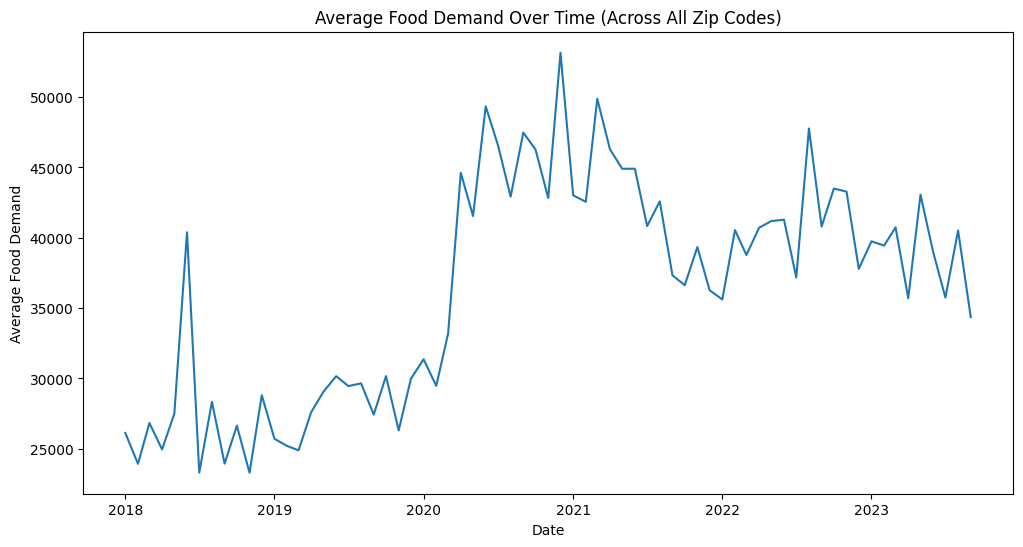

In [ ]:
import matplotlib.pyplot as plt


# Convert 'Date' to datetime and set as index
df_food['Date'] = pd.to_datetime(df_food['Date'])
df_food.sort_values('Date', inplace=True)

# Calculate the average food demand for each date
average_demand = df_food.groupby('Date')['Food_Demand'].mean().reset_index()

# Plotting without markers and legend
plt.figure(figsize=(12, 6))
plt.plot(average_demand['Date'], average_demand['Food_Demand'], label='Average Food Demand', linestyle='-')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Average Food Demand')
plt.title('Average Food Demand Over Time (Across All Zip Codes)')

# Show the plot
plt.show()


In [ ]:
average_demand.head()

Date   Food_Demand
0 2018-01-01  26130.380586
1 2018-02-01  23936.792253
2 2018-03-01  26834.627215
3 2018-04-01  24960.924054
4 2018-05-01  27496.127048

In [ ]:
average_zillow_rent = zillow_rent.groupby('year_month')['Average Rent'].mean().reset_index()
average_zillow_rent.head()

year_month  Average Rent
0    2018-01   2095.489858
1    2018-02   2093.947891
2    2018-03   2117.054186
3    2018-04   2127.721780
4    2018-05   2151.374705

In [ ]:
average_demand['year_month'] = average_demand['Date'].dt.to_period('M')
average_demand = average_demand.drop(columns = ['Date'])
average_demand.head()

Food_Demand year_month
0  26130.380586    2018-01
1  23936.792253    2018-02
2  26834.627215    2018-03
3  24960.924054    2018-04
4  27496.127048    2018-05

In [ ]:
rent_food = pd.merge(df_food, average_zillow_rent, on=['year_month'])
rent_food.head()

Date ZipCode  During_Pandemic  After_Pandemic  Food_Demand year_month  \
0 2018-01-01   91901                0               0    7884.0000    2018-01   
1 2018-01-01   92101                0               0   24806.3305    2018-01   
2 2018-01-01   91941                0               0   12005.7830    2018-01   
3 2018-01-01   92036                0               0   24956.2410    2018-01   
4 2018-01-01   92103                0               0   18683.4405    2018-01   

   Average Rent  
0   2095.489858  
1   2095.489858  
2   2095.489858  
3   2095.489858  
4   2095.489858

In [ ]:
rent_food = merged_rent_food.groupby('year_month')[['Food_Demand', 'Average Rent']].mean().reset_index()

rent_food.head()

rent_food = rent_food.set_index('year_month')

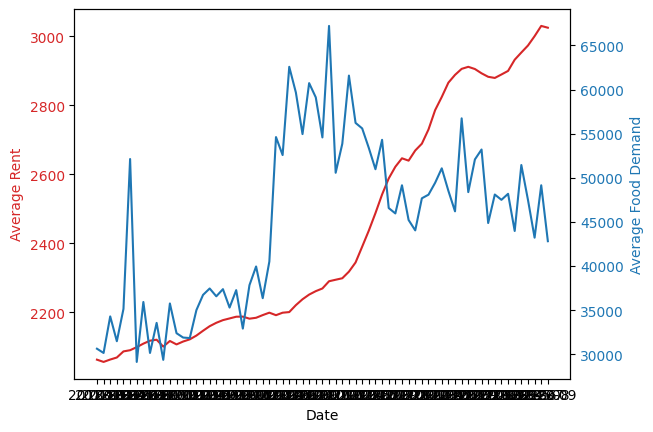

In [ ]:
# Create the first plot
fig, ax1 = plt.subplots()


# Plot 'rent' data
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Rent', color=color)
ax1.plot(rent_food.index, rent_food['Average Rent'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


# Create a second y-axis for the 'food_demand' data
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Food Demand', color=color)
ax2.plot(rent_food.index, rent_food['Food_Demand'], color=color)
ax2.tick_params(axis='y', labelcolor=color)


# Show the plot
plt.show()


In [ ]:
average_demand.head()

Food_Demand year_month
0  26130.380586    2018-01
1  23936.792253    2018-02
2  26834.627215    2018-03
3  24960.924054    2018-04
4  27496.127048    2018-05

In [ ]:
zillow_rent.head()

Date ZipCode  Average Rent  During_Pandemic  After_Pandemic  \
0 2018-01-31   91902           NaN                0               0   
1 2018-02-28   91902           NaN                0               0   
2 2018-03-31   91902           NaN                0               0   
3 2018-04-30   91902           NaN                0               0   
4 2018-05-31   91902           NaN                0               0   

  Time_Period year_month  
0         Pre    2018-01  
1         Pre    2018-02  
2         Pre    2018-03  
3         Pre    2018-04  
4         Pre    2018-05

In [ ]:
# Filter for the post-pandemic period
#post_pandemic_df = merged_rent_food[merged_rent_food['after pandemic'] == 1]

# Create a correlation matrix
#correlation_matrix = post_pandemic_df[['Food_Demand', 'average rent']].corr()

# Plotting the correlation matrix
#plt.figure(figsize=(10, 6))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
#plt.title('Correlation between Food Demand and Average Rent (Post-Pandemic)')
#plt.show()

# Scatter plot for food demand vs. average rent
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='average rent', y='Food_Demand', data=post_pandemic_df)
#plt.title('Food Demand vs. Average Rent (Post-Pandemic)')
#plt.xlabel('Average Rent')
#plt.ylabel('Food Demand')
#plt.show()

## BLS Statistics

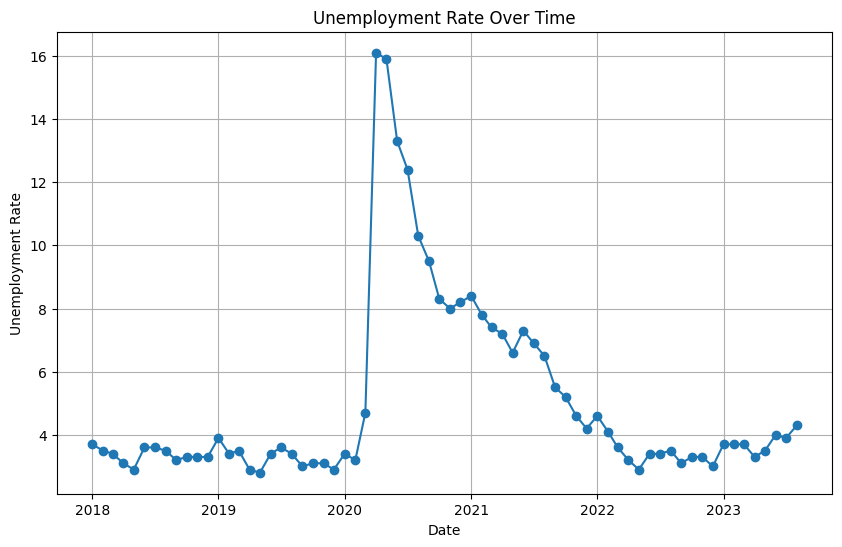

In [ ]:
# Assuming df_unemployment is your DataFrame
# Convert 'Date' to datetime format
df_unemployment['Date'] = pd.to_datetime(df_unemployment['Date'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_unemployment['Date'], df_unemployment['Unemployment Rate'], marker='o', linestyle='-')
plt.title('Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.show()

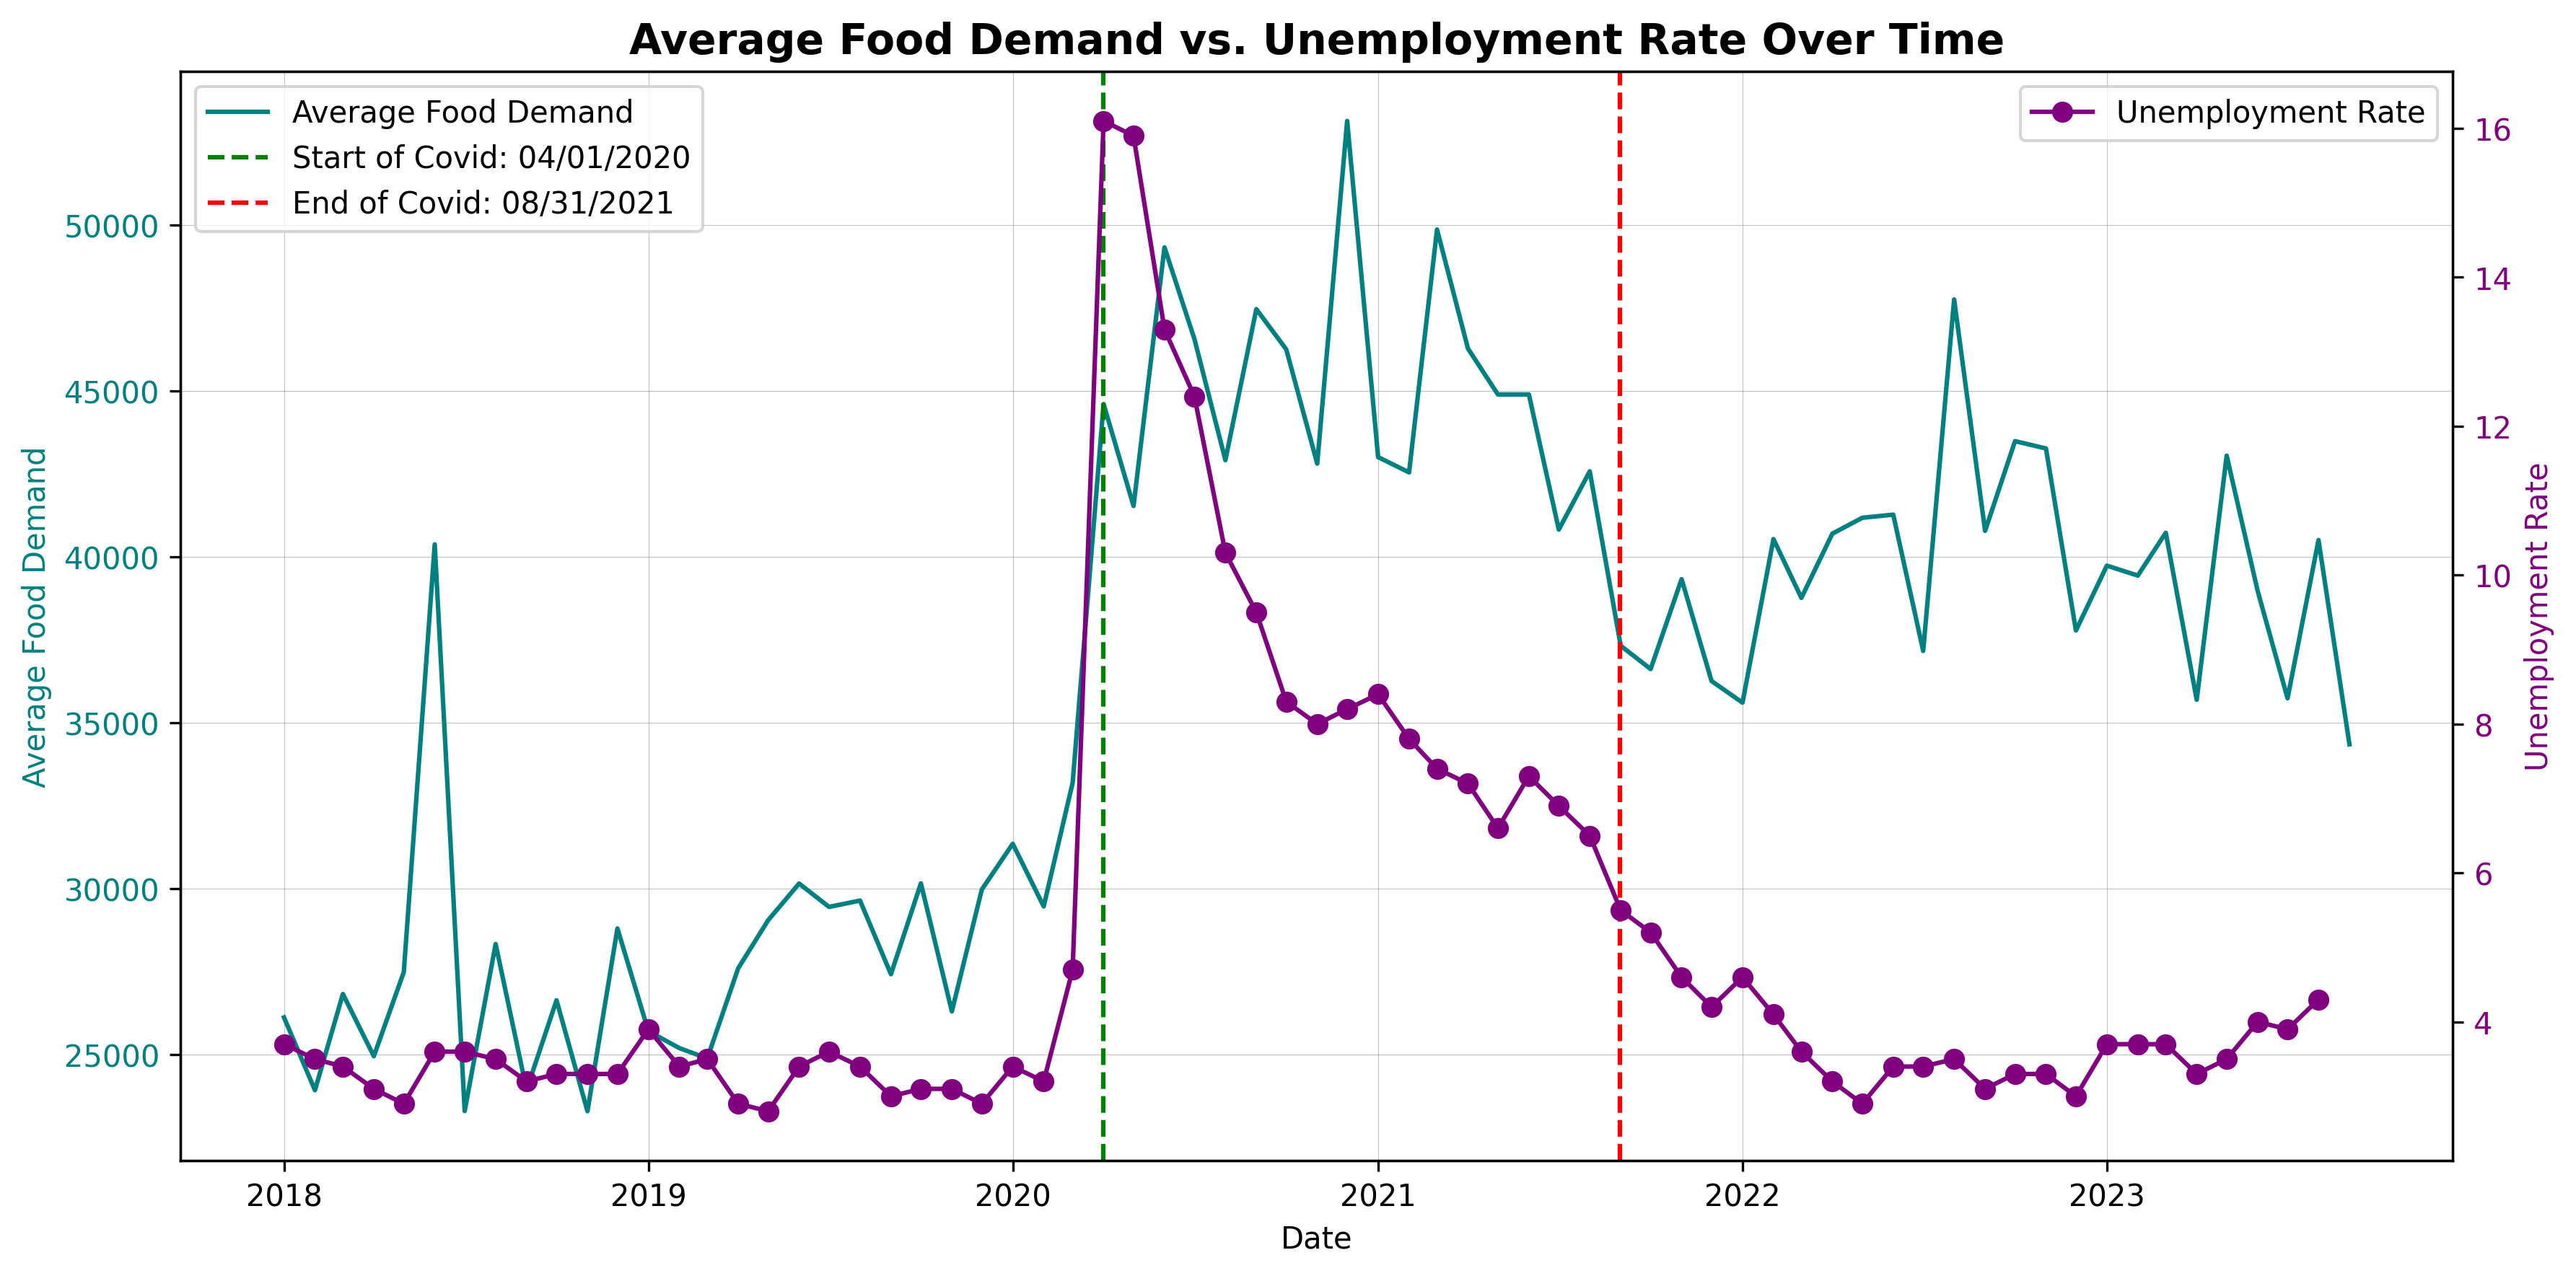

In [ ]:
# Assuming df_unemployment and df_food are your DataFrames
# Convert 'Date' to datetime format in both DataFrames
df_unemployment['Date'] = pd.to_datetime(df_unemployment['Date'])
df_food['Date'] = pd.to_datetime(df_food['Date'])

# Group by Date and calculate the average Food Demand for all zip codes over time
average_demand_over_time = df_food.groupby('Date')['Food_Demand'].mean().reset_index()

# Pandemic start and end dates
start_pandemic = pd.Timestamp('2020-04-01')
end_pandemic = pd.Timestamp('2021-08-31')

# Creating a dual axis line graph
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)

# Plotting Food Demand on the primary y-axis
ax1.plot(average_demand_over_time['Date'], average_demand_over_time['Food_Demand'], color='teal', label='Average Food Demand')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Food Demand', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.axvline(start_pandemic, color='green', linestyle='--', label='Start of Covid: 04/01/2020')
ax1.axvline(end_pandemic, color='red', linestyle='--', label='End of Covid: 08/31/2021')
ax1.legend(loc='upper left')

# Creating a second y-axis for Unemployment Rate
ax2 = ax1.twinx()
ax2.plot(df_unemployment['Date'], df_unemployment['Unemployment Rate'], marker='o', linestyle='-', color='purple', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

# Title and grid
plt.title('Average Food Demand vs. Unemployment Rate Over Time', fontsize=14, fontweight='bold')
ax1.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()


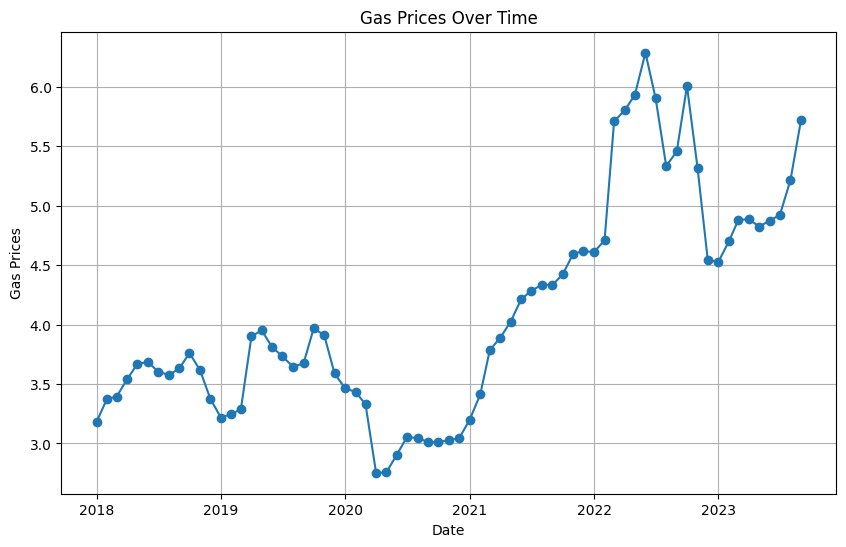

In [ ]:
# Assuming df_gas is your DataFrame
# Convert 'Date' to datetime format
df_gas['Date'] = pd.to_datetime(df_gas['Date'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_gas['Date'], df_gas['Gas Prices'], marker='o', linestyle='-')
plt.title('Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Gas Prices')
plt.grid(True)
plt.show()

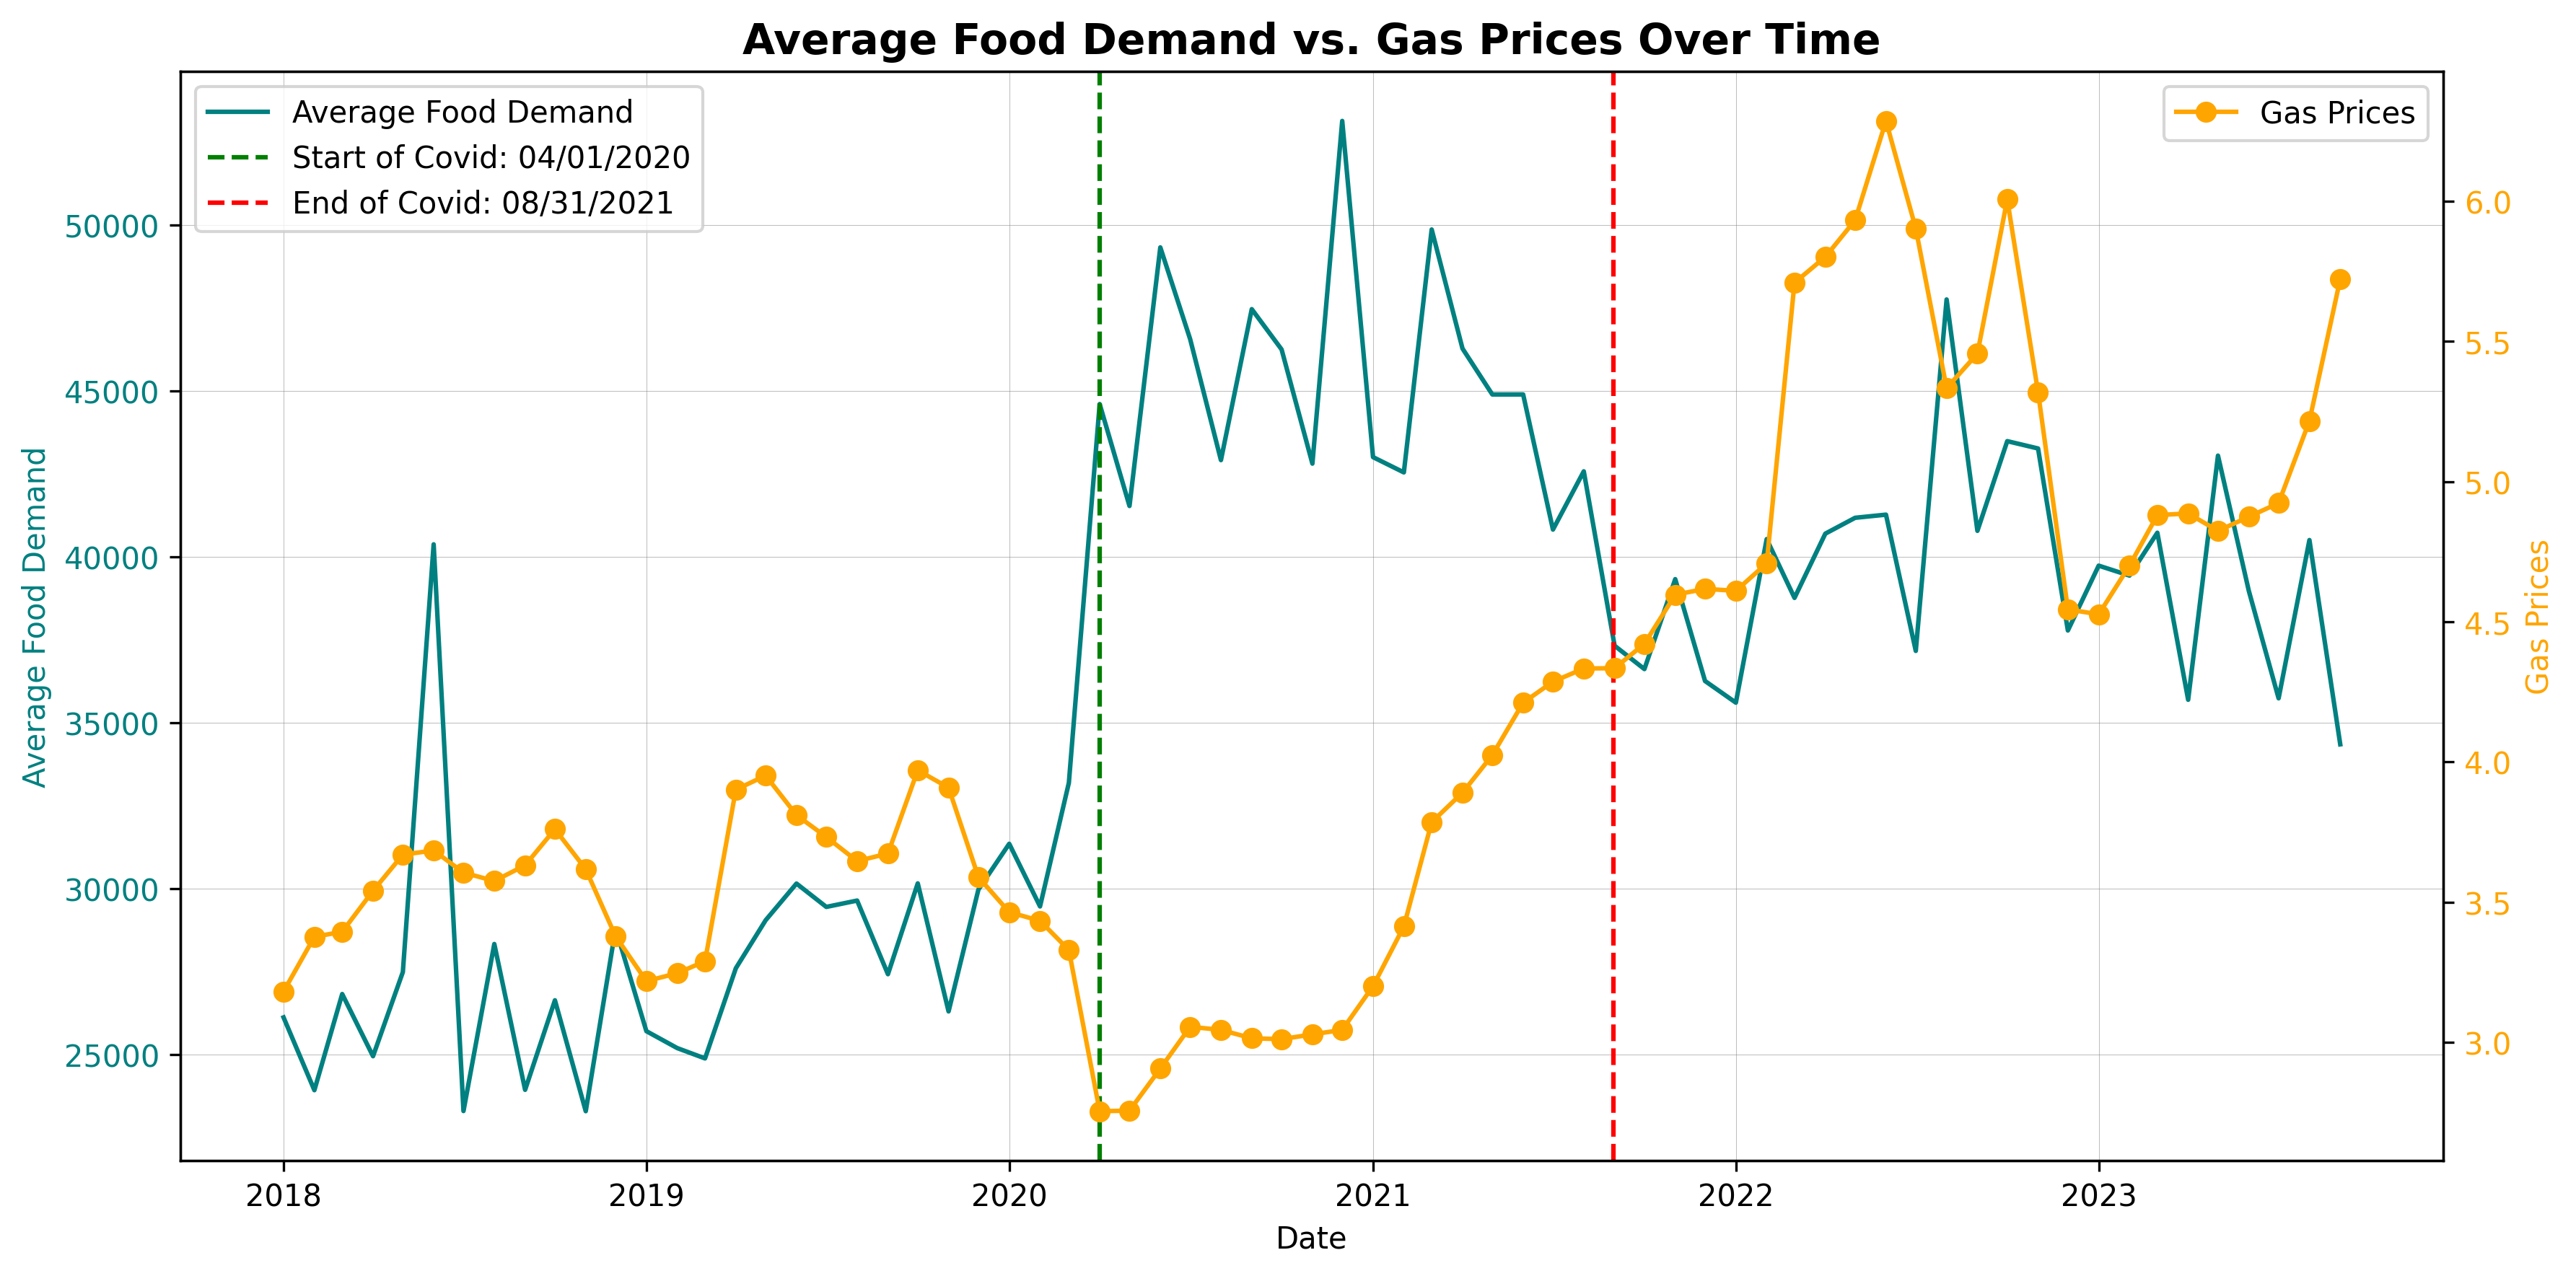

In [ ]:
# Assuming df_gas and df_food are your DataFrames
# Convert 'Date' to datetime format in both DataFrames
df_gas['Date'] = pd.to_datetime(df_gas['Date'])
df_food['Date'] = pd.to_datetime(df_food['Date'])

# Group by Date and calculate the average Food Demand for all zip codes over time
average_demand_over_time = df_food.groupby('Date')['Food_Demand'].mean().reset_index()

# Pandemic start and end dates
start_pandemic = pd.Timestamp('2020-04-01')
end_pandemic = pd.Timestamp('2021-08-31')

# Creating a dual axis line graph
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)

# Plotting Food Demand on the primary y-axis
ax1.plot(average_demand_over_time['Date'], average_demand_over_time['Food_Demand'], color='teal', label='Average Food Demand')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Food Demand', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.axvline(start_pandemic, color='green', linestyle='--', label='Start of Covid: 04/01/2020')
ax1.axvline(end_pandemic, color='red', linestyle='--', label='End of Covid: 08/31/2021')
ax1.legend(loc='upper left')

# Creating a second y-axis for Gas Prices
ax2 = ax1.twinx()
ax2.plot(df_gas['Date'], df_gas['Gas Prices'], marker='o', linestyle='-', color='orange', label='Gas Prices')
ax2.set_ylabel('Gas Prices', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Title and grid
plt.title('Average Food Demand vs. Gas Prices Over Time', fontsize=14, fontweight='bold')
ax1.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()

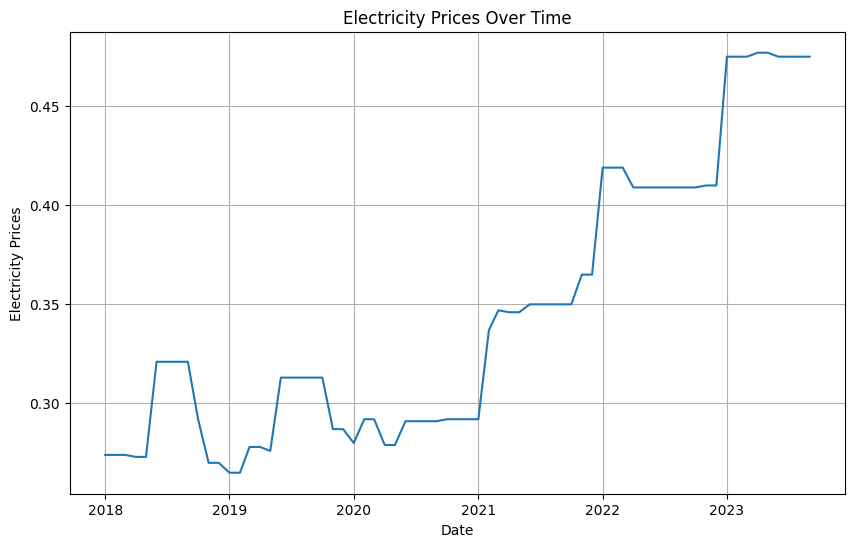

In [ ]:
# Convert 'Date' to datetime format
df_electricity['Date'] = pd.to_datetime(df_electricity['Date'])

# Plotting without markers
plt.figure(figsize=(10, 6))
plt.plot(df_electricity['Date'], df_electricity['Electricity Prices'], linestyle='-')
plt.title('Electricity Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Electricity Prices')
plt.grid(True)
plt.show()

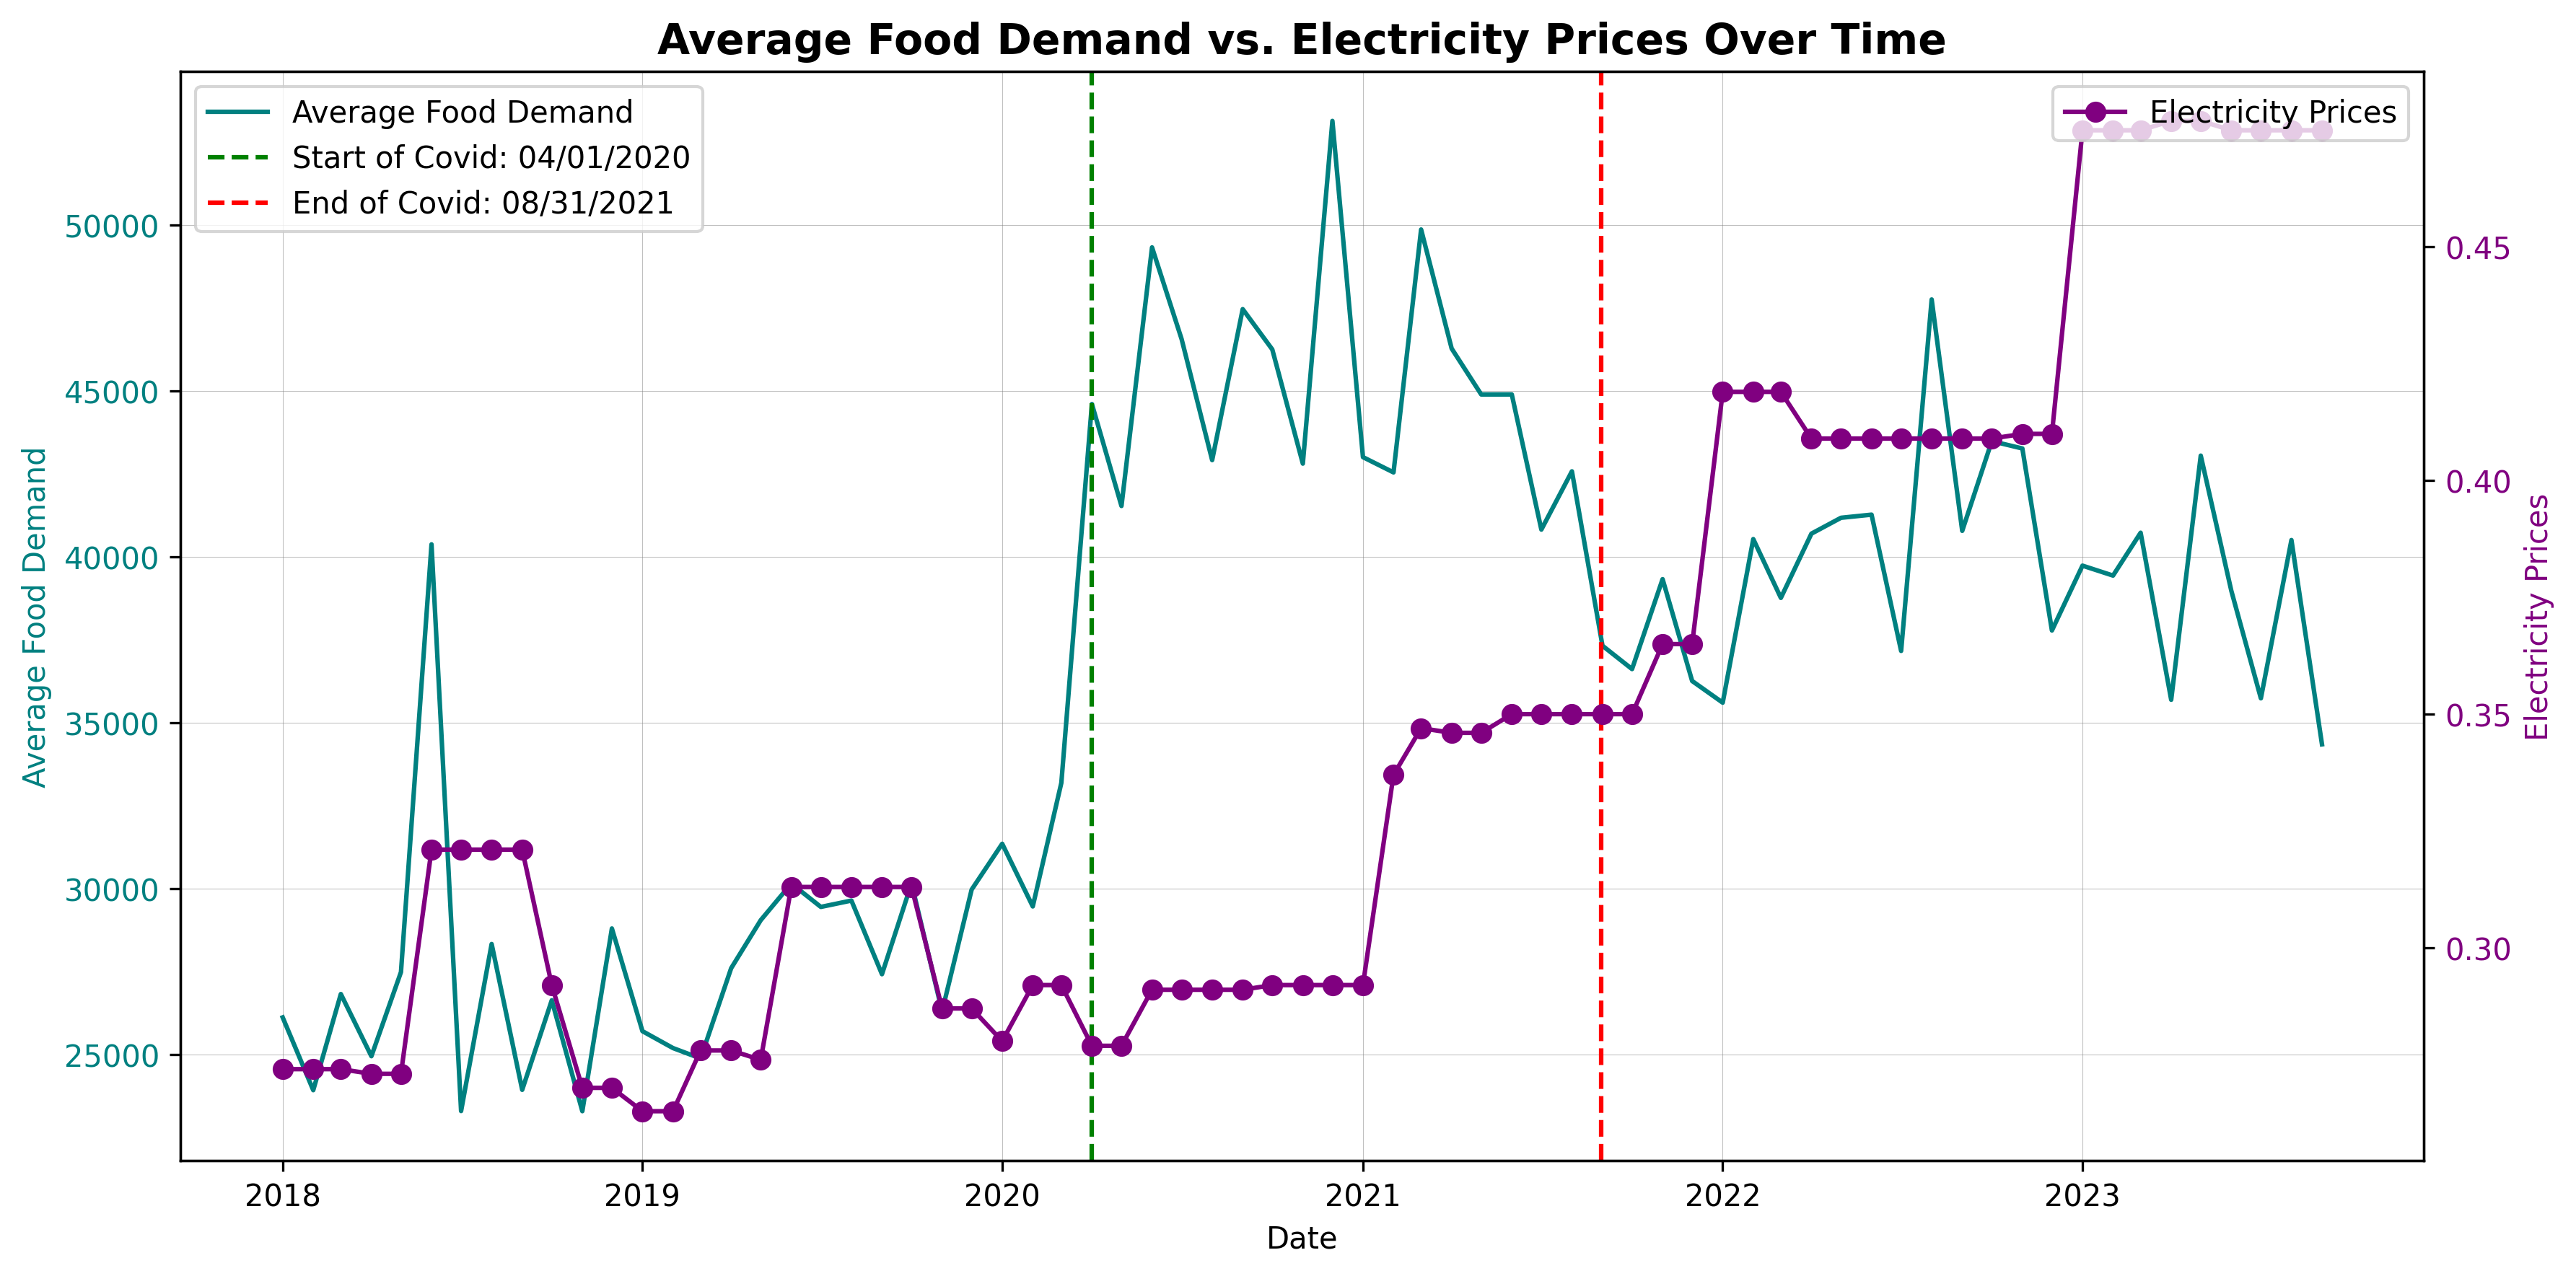

In [ ]:
# Assuming df_electricity and df_food are your DataFrames
# Convert 'Date' to datetime format in both DataFrames
df_electricity['Date'] = pd.to_datetime(df_electricity['Date'])
df_food['Date'] = pd.to_datetime(df_food['Date'])

# Group by Date and calculate the average Food Demand for all zip codes over time
average_demand_over_time = df_food.groupby('Date')['Food_Demand'].mean().reset_index()

# Pandemic start and end dates
start_pandemic = pd.Timestamp('2020-04-01')
end_pandemic = pd.Timestamp('2021-08-31')

# Creating a dual axis line graph
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)

# Plotting Food Demand on the primary y-axis
ax1.plot(average_demand_over_time['Date'], average_demand_over_time['Food_Demand'], color='teal', label='Average Food Demand')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Food Demand', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.axvline(start_pandemic, color='green', linestyle='--', label='Start of Covid: 04/01/2020')
ax1.axvline(end_pandemic, color='red', linestyle='--', label='End of Covid: 08/31/2021')
ax1.legend(loc='upper left')

# Creating a second y-axis for Electricity Prices
ax2 = ax1.twinx()
ax2.plot(df_electricity['Date'], df_electricity['Electricity Prices'],marker = 'o', linestyle='-', color='purple', label='Electricity Prices')
ax2.set_ylabel('Electricity Prices', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

# Title and grid
plt.title('Average Food Demand vs. Electricity Prices Over Time', fontsize=14, fontweight='bold')
ax1.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()


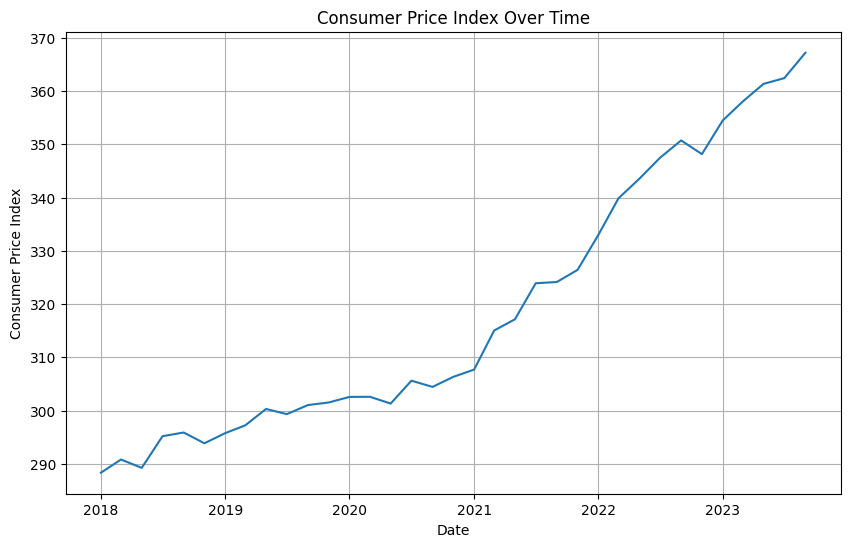

In [ ]:
# Convert 'Date' to datetime format
df_cpi['Date'] = pd.to_datetime(df_cpi['Date'])

# Plotting without markers
plt.figure(figsize=(10, 6))
plt.plot(df_cpi['Date'], df_cpi['Consumer Price Index'], linestyle='-')
plt.title('Consumer Price Index Over Time')
plt.xlabel('Date')
plt.ylabel('Consumer Price Index')
plt.grid(True)

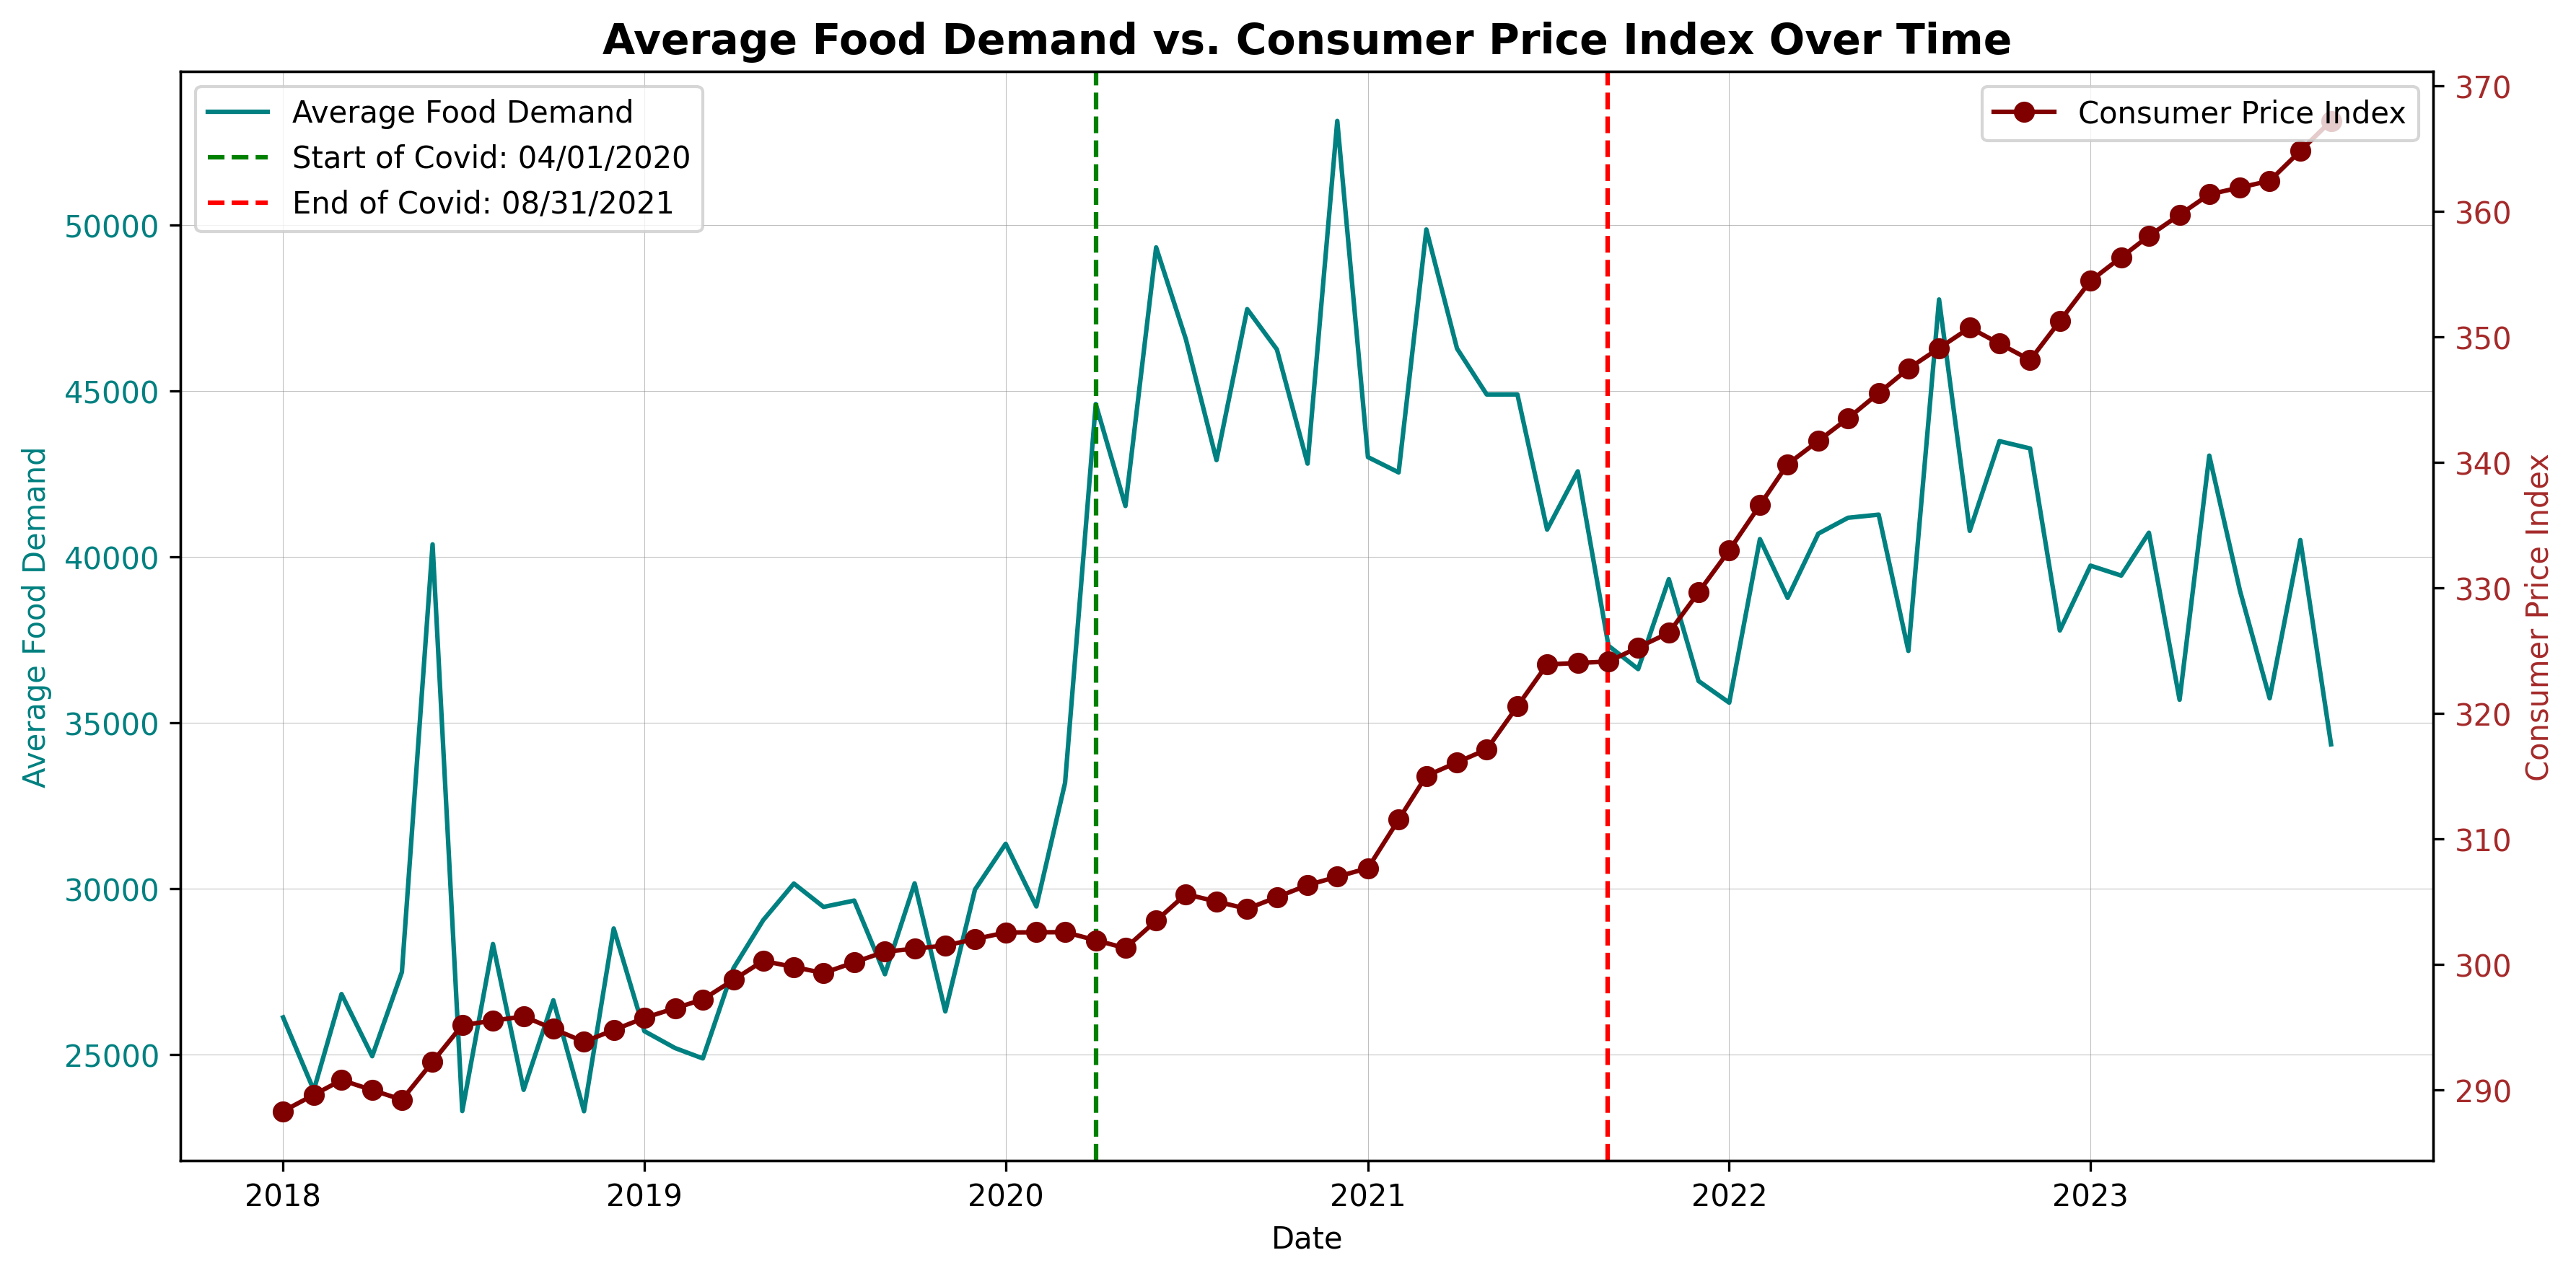

In [ ]:
# Assuming df_cpi and df_food are your DataFrames
# Convert 'Date' to datetime format in both DataFrames
df_cpi['Date'] = pd.to_datetime(df_cpi['Date'])
df_food['Date'] = pd.to_datetime(df_food['Date'])

# Group by Date and calculate the average Food Demand for all zip codes over time
average_demand_over_time = df_food.groupby('Date')['Food_Demand'].mean().reset_index()

# Pandemic start and end dates
start_pandemic = pd.Timestamp('2020-04-01')
end_pandemic = pd.Timestamp('2021-08-31')

# Creating a dual axis line graph
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)

# Plotting Food Demand on the primary y-axis
ax1.plot(average_demand_over_time['Date'], average_demand_over_time['Food_Demand'], color='teal', label='Average Food Demand')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Food Demand', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.axvline(start_pandemic, color='green', linestyle='--', label='Start of Covid: 04/01/2020')
ax1.axvline(end_pandemic, color='red', linestyle='--', label='End of Covid: 08/31/2021')
ax1.legend(loc='upper left')

# Creating a second y-axis for Consumer Price Index
ax2 = ax1.twinx()
ax2.plot(df_cpi['Date'], df_cpi['Consumer Price Index'], linestyle='-',marker = 'o', color='maroon', label='Consumer Price Index')
ax2.set_ylabel('Consumer Price Index', color='brown')
ax2.tick_params(axis='y', labelcolor='brown')
ax2.legend(loc='upper right')

# Title and grid
plt.title('Average Food Demand vs. Consumer Price Index Over Time', fontsize=14, fontweight='bold')
ax1.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()


## Demographic Analysis

In [ ]:
df_demo.columns

Index(['Zip Code', 'Population', 'Veteran Population', 'White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander', 'Other Race',
       'Two or More Races', 'Not Hispanic or Latino Origin',
       'Hispanic or Latino Origin', 'Renter Population',
       'Population in Poverty', 'Population with Disability',
       'Senior Population (60y+)', 'Households Receiving SNAP',
       'Median Income', 'Youth Population', 'Unemployment',
       'Food_Insecurity_Estimate', 'Food_Insecure_Population',
       'LIHEAP Request'],
      dtype='object')

In [ ]:
df_demo = df_demo.rename(columns={'Zip Code': 'Zip_Code'})

In [ ]:
df_output_z_demo = df_output_z_demo.rename(columns={'ZipCode': 'Zip_Code'})

df_output_z_demo.head()

Zip_Code  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0    91901  4  1  0                   -1952.000003            -8805.999969   
1    91912  3  1  0                    1749.000044             1060.999951   
2    92165  3  1  2                    7526.061884             4738.974366   
3    92116  1  1  1                    8857.420374             -650.080183   
4    92004  1  1  1                     403.110241             4531.849917   

   During Covid Z-Score  After Covid Z-Score  Average_Before_Covid  \
0             -0.474061            -0.596837           9847.111111   
1             -0.343071            -0.201953           4143.018167   
2             -0.138602            -0.054758           2176.703704   
3             -0.091481            -0.270432          32549.051667   
4             -0.390706            -0.063048           9610.054537   

   Change_In_Food_Demand_During_Covid  Change_In_Food_Demand_After_Covid  
0                          -19.823073                         -89.427243  
1                           42.215602                          25.609348  
2                          345.755000                         217.713341  
3                           27.212530                          -1.997232  
4                            4.194672                          47.157380

In [ ]:
df_output_z.head()

ZipCode  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0   91901  4  1  0                   -1952.000003            -8805.999969   
1   91912  3  1  0                    1749.000044             1060.999951   
2   92165  3  1  2                    7526.061884             4738.974366   
3   92116  1  1  1                    8857.420374             -650.080183   
4   92004  1  1  1                     403.110241             4531.849917   

           AIC          BIC  During Covid Z-Score  After Covid Z-Score  
0  1410.088209  1425.624763             -0.474061            -0.596837  
1  1210.362205  1223.679251             -0.343071            -0.201953  
2  1261.376214  1279.132276             -0.138602            -0.054758  
3  1467.240280  1478.337818             -0.091481            -0.270432  
4  1270.293904  1281.391442             -0.390706            -0.063048

In [ ]:
# Function to process the dataframes and perform regression

def perform_regression(df_output_z, df_demo):
    df_output_z = df_output_z.rename(columns={'ZipCode': 'Zip_Code'})
    # Ensure 'Zip_Code' is a string
    df_output_z['Zip_Code'] = df_output_z['Zip_Code'].astype(str)
    df_demo['Zip_Code'] = df_demo['Zip_Code'].astype(str)
    # Correct column names to ensure compatibility with regression formulas
    df_output_z.columns = df_output_z.columns.str.replace(' ', '_').str.replace(r'[^A-Za-z0-9_]', '', regex=True)
    df_demo.columns = df_demo.columns.str.replace(' ', '_').str.replace(r'[^A-Za-z0-9_]', '', regex=True)
    # Merging the datasets on 'Zip_Code'
    merged_data_d = pd.merge(df_output_z, df_demo, on='Zip_Code')
    # List of independent variables (excluding 'Population')
    independent_variables = [col for col in df_demo.columns if col not in ['Zip_Code', 'Population']]
    # Store regression results
    regression_results = []
    # Performing regression for each metric
    for var in independent_variables:
        # Create the formula for regression
        formula = f'During_Covid_Beta_Coefficient ~ {var}'
        # Run the regression model
        model = ols(formula, data=merged_data_d).fit()
        # Retrieve coefficients and p-values
        coeff = model.params[var]
        p_value = model.pvalues[var]
        # Append results
        regression_results.append({'Variable': var, 'Coefficient': coeff, 'P-Value': p_value})

    # Convert the results to a DataFrame and return
    return pd.DataFrame(regression_results)

# Usage (Assuming df_output_z and df_demo are already loaded in your environment)
regression_demo_df = perform_regression(df_output_z, df_demo)


In [ ]:
regression_demo_df.head()

Variable  Coefficient   P-Value
0                 Veteran_Population   -74.175316  0.938520
1                              White   -86.918406  0.723875
2          Black_or_African_American  1396.757089  0.095112
3  American_Indian_and_Alaska_Native  -672.303432  0.328850
4                              Asian    91.144952  0.797186

In [ ]:
df_output_z = df_output_z.rename(columns={'ZipCode': 'Zip_Code'})
df_output_z = df_output_z.rename(columns={'During Covid Beta Coefficient': 'During_Covid_Beta_Coefficient'})

df_output_z.head()

Zip_Code  p  d  q  During_Covid_Beta_Coefficient  After Beta Coefficient  \
0    91901  4  1  0                   -1952.000003            -8805.999969   
1    91912  3  1  0                    1749.000044             1060.999951   
2    92165  3  1  2                    7526.061884             4738.974366   
3    92116  1  1  1                    8857.420374             -650.080183   
4    92004  1  1  1                     403.110241             4531.849917   

           AIC          BIC  During Covid Z-Score  After Covid Z-Score  
0  1410.088209  1425.624763             -0.474061            -0.596837  
1  1210.362205  1223.679251             -0.343071            -0.201953  
2  1261.376214  1279.132276             -0.138602            -0.054758  
3  1467.240280  1478.337818             -0.091481            -0.270432  
4  1270.293904  1281.391442             -0.390706            -0.063048

In [ ]:
df_output_z.columns

Index(['Zip_Code', 'p', 'd', 'q', 'During_Covid_Beta_Coefficient',
       'After Beta Coefficient', 'AIC', 'BIC', 'During Covid Z-Score',
       'After Covid Z-Score'],
      dtype='object')

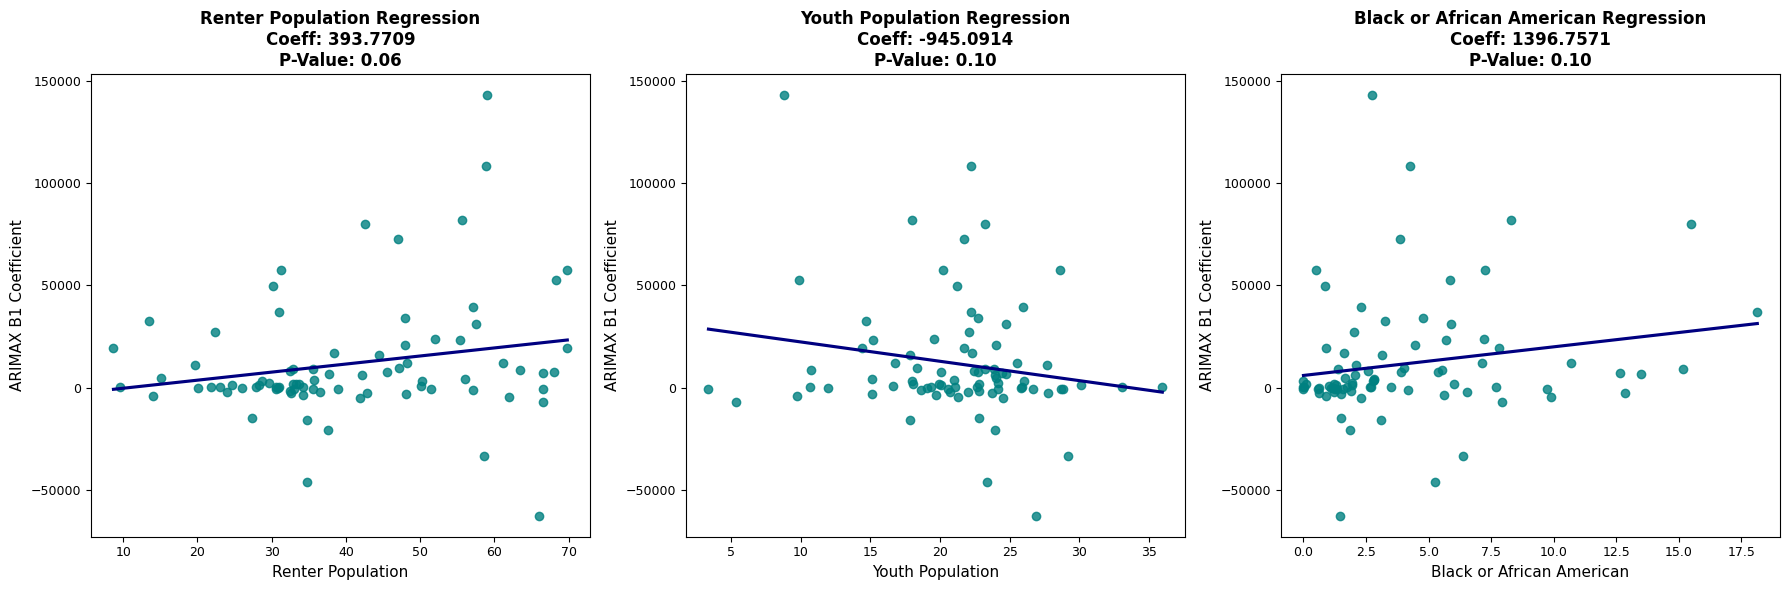

In [ ]:
# Merge the datasets on a common column, assuming it's 'ZipCode'
df_merged_d = pd.merge(df_output_z, df_demo, on='Zip_Code')

# List of independent variables
independent_vars = ['Renter_Population', 'Youth_Population', 'Black_or_African_American']

plt.figure(figsize=(18, 6))

for i, var in enumerate(independent_vars, 1):
    # Create regression model
    model = ols(f'During_Covid_Beta_Coefficient ~ {var}', data=df_merged_d).fit()

    # Extract formula and p-value, rounded to 2 decimals
    formula = f'Coeff: {model.params[var]:.4f}\nP-Value: {model.pvalues[var]:.2f}'

    # Plot
    plt.subplot(1, 3, i)
    sns.regplot(x=var, y='During_Covid_Beta_Coefficient', data=df_merged_d, ci=None, color='teal', line_kws={'color':'navy'})
    plt.title(f'{var.replace("_", " ")} Regression\n{formula}', fontsize=12, fontweight='bold')
    plt.xlabel(f'{var.replace("_", " ")}', fontsize=11)
    plt.ylabel('ARIMAX B1 Coefficient', fontsize=11)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
df_demo.columns

Index(['Zip_Code', 'Population', 'Veteran_Population', 'White',
       'Black_or_African_American', 'American_Indian_and_Alaska_Native',
       'Asian', 'Native_Hawaiian_and_Other_Pacific_Islander', 'Other_Race',
       'Two_or_More_Races', 'Not_Hispanic_or_Latino_Origin',
       'Hispanic_or_Latino_Origin', 'Renter_Population',
       'Population_in_Poverty', 'Population_with_Disability',
       'Senior_Population_60y', 'Households_Receiving_SNAP', 'Median_Income',
       'Youth_Population', 'Unemployment', 'Food_Insecurity_Estimate',
       'Food_Insecure_Population', 'LIHEAP_Request'],
      dtype='object')

In [ ]:
df_output_z_demo.columns

Index(['Zip_Code', 'p', 'd', 'q', 'During Covid Beta Coefficient',
       'After Beta Coefficient', 'During Covid Z-Score', 'After Covid Z-Score',
       'Average_Before_Covid', 'Change_In_Food_Demand_During_Covid',
       'Change_In_Food_Demand_After_Covid'],
      dtype='object')

In [ ]:
df_output_z_demo=df_output_z_demo.rename(columns={'ZipCode': 'Zip_Code'})
df_output_z_demo.head()

Zip_Code  p  d  q  During Covid Beta Coefficient  After Beta Coefficient  \
0    91901  4  1  0                   -1952.000003            -8805.999969   
1    91912  3  1  0                    1749.000044             1060.999951   
2    92165  3  1  2                    7526.061884             4738.974366   
3    92116  1  1  1                    8857.420374             -650.080183   
4    92004  1  1  1                     403.110241             4531.849917   

   During Covid Z-Score  After Covid Z-Score  Average_Before_Covid  \
0             -0.474061            -0.596837           9847.111111   
1             -0.343071            -0.201953           4143.018167   
2             -0.138602            -0.054758           2176.703704   
3             -0.091481            -0.270432          32549.051667   
4             -0.390706            -0.063048           9610.054537   

   Change_In_Food_Demand_During_Covid  Change_In_Food_Demand_After_Covid  
0                          -19.823073                         -89.427243  
1                           42.215602                          25.609348  
2                          345.755000                         217.713341  
3                           27.212530                          -1.997232  
4                            4.194672                          47.157380

In [ ]:
def perform_regression(df_output_z_demo, df_demo):

    df_output_z_demo['Zip_Code'] = df_output_z_demo['Zip_Code'].astype(str)
    df_demo['Zip_Code'] = df_demo['Zip_Code'].astype(str)

    # Rename 'ZipCode' to 'Zip_Code' in df_output_z_demo
    df_output_z_demo.rename(columns={'ZipCode': 'Zip_Code'}, inplace=True)

    # Correct column names to ensure compatibility with regression formulas
    df_output_z_demo.columns = df_output_z_demo.columns.str.replace(' ', '_').str.replace(r'[^A-Za-z0-9_]', '', regex=True)
    df_demo.columns = df_demo.columns.str.replace(' ', '_').str.replace(r'[^A-Za-z0-9_]', '', regex=True)

    # Merging the datasets on 'Zip_Code'
    merged_data_demo = pd.merge(df_output_z_demo, df_demo, on='Zip_Code')

    # List of independent variables (excluding 'Population')
    independent_variables = df_demo.columns.drop(['Zip_Code', 'Population'])

    # Store regression results
    regression_results = []

    # Performing regression for each metric
    for var in independent_variables:
        formula = f'Change_In_Food_Demand_During_Covid ~ {var}'
        model = ols(formula, data=merged_data_demo).fit()
        coeff = model.params[var]
        p_value = model.pvalues[var]
        regression_results.append({'Variable': var, 'Coefficient': coeff, 'P-Value': p_value})

    # Convert the results to a DataFrame and return
    return pd.DataFrame(regression_results)

# Usage
# Assuming df_output_z_demo and df_demo are already loaded in your environment
percent_regression_demo_df = perform_regression(df_output_z_demo, df_demo)



In [ ]:
percent_regression_demo_df.head()

Variable  Coefficient   P-Value
0                 Veteran_Population    -0.642009  0.877517
1                              White     0.048174  0.963899
2          Black_or_African_American    -0.342167  0.925374
3  American_Indian_and_Alaska_Native    -4.136571  0.160233
4                              Asian     3.160326  0.043330

In [ ]:
df_output_z.head()

Zip_Code  p  d  q  During_Covid_Beta_Coefficient  After Beta Coefficient  \
0    91901  4  1  0                   -1952.000003            -8805.999969   
1    91912  3  1  0                    1749.000044             1060.999951   
2    92165  3  1  2                    7526.061884             4738.974366   
3    92116  1  1  1                    8857.420374             -650.080183   
4    92004  1  1  1                     403.110241             4531.849917   

           AIC          BIC  During Covid Z-Score  After Covid Z-Score  
0  1410.088209  1425.624763             -0.474061            -0.596837  
1  1210.362205  1223.679251             -0.343071            -0.201953  
2  1261.376214  1279.132276             -0.138602            -0.054758  
3  1467.240280  1478.337818             -0.091481            -0.270432  
4  1270.293904  1281.391442             -0.390706            -0.063048

In [ ]:
# Compute the average for each column variable
df_demo_averages = df_demo.mean().to_frame('Average').reset_index()
df_demo_averages.columns = ['Variable', 'Average']

# Display the first few rows
df_demo_averages.head(15).T

0             1                   2          3   \
Variable  Zip_Code    Population  Veteran_Population      White   
Average        inf  28868.903509            6.802438  65.907999   

                                 4                                  5   \
Variable  Black_or_African_American  American_Indian_and_Alaska_Native   
Average                    4.869931                           1.870393   

                6                                           7           8   \
Variable     Asian  Native_Hawaiian_and_Other_Pacific_Islander  Other_Race   
Average   9.011668                                    0.352258    7.009398   

                         9                              10  \
Variable  Two_or_More_Races  Not_Hispanic_or_Latino_Origin   
Average           10.978354                      69.953552   

                                 11                 12                     13  \
Variable  Hispanic_or_Latino_Origin  Renter_Population  Population_in_Poverty   
Average                   30.046448          35.612679              16.251626   

                                  14  
Variable  Population_with_Disability  
Average                     9.176622

In [ ]:
# Rename the 'Zip Code' column in df_demo and region_info to match 'ZipCode' in df_output_z
df_demo = df_demo.rename(columns={'Zip_Code': 'ZipCode'})
df_region = df_region.rename(columns={'Zip Code': 'ZipCode'})
df_output_z = df_output_z.rename(columns={'Zip_Code': 'ZipCode'})


df_merged['ZipCode'] = df_merged['ZipCode'].astype(str)
df_region['ZipCode'] = df_region['ZipCode'].astype(str)

# Merge the datasets on the 'ZipCode' column
df_merged = pd.merge(df_output_z, df_demo, on='ZipCode')
df_merged = pd.merge(df_merged, df_region, on='ZipCode')

df_merged.head()

ZipCode  p  d  q  During_Covid_Beta_Coefficient  After Beta Coefficient  \
0   91901  4  1  0                   -1952.000003            -8805.999969   
1   92116  1  1  1                    8857.420374             -650.080183   
2   92021  1  1  1                   12014.587485             4031.847046   
3   92084  1  1  2                    6230.349534             7035.266447   
4   91942  1  1  1                   23972.780031            24498.279964   

           AIC          BIC  During Covid Z-Score  After Covid Z-Score  ...  \
0  1410.088209  1425.624763             -0.474061            -0.596837  ...   
1  1467.240280  1478.337818             -0.091481            -0.270432  ...   
2  1522.121471  1533.219009              0.020261            -0.083058  ...   
3  1388.091776  1401.408823             -0.184461             0.037141  ...   
4  1482.094274  1493.191812              0.443500             0.736023  ...   

   Population_with_Disability  Senior_Population_60y  \
0                   10.023412                    NaN   
1                    7.343502                    NaN   
2                   13.624201              20.915134   
3                    7.397657              17.729456   
4                   11.854245              21.302890   

   Households_Receiving_SNAP  Median_Income  Youth_Population  Unemployment  \
0                   1.638809     575.374313         21.990526      0.014257   
1                   2.497617     266.504608         10.721322      0.008883   
2                   5.957243      89.281188         25.521787      0.007015   
3                   1.794650     171.124822         23.915272      0.007103   
4                   3.330641     176.553361         19.545799      0.008216   

   Food_Insecurity_Estimate  Food_Insecure_Population  LIHEAP_Request  \
0                  0.000359                  6.596265       12.408123   
1                  0.000237                  7.455646       22.565554   
2                  0.000202                 14.355525       11.272287   
3                  0.000136                  6.746850       37.243835   
4                  0.000272                 11.109195       42.058537   

        RegionName  
0           Alpine  
1   Normal Heights  
2         El Cajon  
3          Vista E  
4        Grossmont  

[5 rows x 33 columns]

In [ ]:
print("df_output_z columns:", df_output_z.columns)
print("df_demo columns:", df_demo.columns)
print("region_info columns:", df_region.columns)

df_output_z columns: Index(['ZipCode', 'p', 'd', 'q', 'During_Covid_Beta_Coefficient',
       'After Beta Coefficient', 'AIC', 'BIC', 'During Covid Z-Score',
       'After Covid Z-Score'],
      dtype='object')
df_demo columns: Index(['ZipCode', 'Population', 'Veteran_Population', 'White',
       'Black_or_African_American', 'American_Indian_and_Alaska_Native',
       'Asian', 'Native_Hawaiian_and_Other_Pacific_Islander', 'Other_Race',
       'Two_or_More_Races', 'Not_Hispanic_or_Latino_Origin',
       'Hispanic_or_Latino_Origin', 'Renter_Population',
       'Population_in_Poverty', 'Population_with_Disability',
       'Senior_Population_60y', 'Households_Receiving_SNAP', 'Median_Income',
       'Youth_Population', 'Unemployment', 'Food_Insecurity_Estimate',
       'Food_Insecure_Population', 'LIHEAP_Request'],
      dtype='object')
region_info columns: Index(['ZipCode', 'RegionName'], dtype='object')


In [ ]:
df_demo['Youth_Population'].describe()

count    107.000000
mean      18.958313
std        8.737844
min        0.000000
25%       15.151907
50%       21.066830
75%       24.096195
max       43.693108
Name: Youth_Population, dtype: float64

## During/After Covid Beta Regression

In [ ]:
df_output_z.head()

ZipCode  p  d  q  During_Covid_Beta_Coefficient  After Beta Coefficient  \
0    91901  4  1  0                   -1952.000003            -8805.999969   
1    91912  3  1  0                    1749.000044             1060.999951   
2    92165  3  1  2                    7526.061884             4738.974366   
3    92116  1  1  1                    8857.420374             -650.080183   
4    92004  1  1  1                     403.110241             4531.849917   

           AIC          BIC  During Covid Z-Score  After Covid Z-Score  
0  1410.088209  1425.624763             -0.474061            -0.596837  
1  1210.362205  1223.679251             -0.343071            -0.201953  
2  1261.376214  1279.132276             -0.138602            -0.054758  
3  1467.240280  1478.337818             -0.091481            -0.270432  
4  1270.293904  1281.391442             -0.390706            -0.063048

In [ ]:
df_output_z = df_output_z.rename(columns={'During Covid Z-Score': 'During_Covid_ZScore'})
df_output_z = df_output_z.rename(columns={'After Covid Z-Score': 'After_Covid_ZScore'})

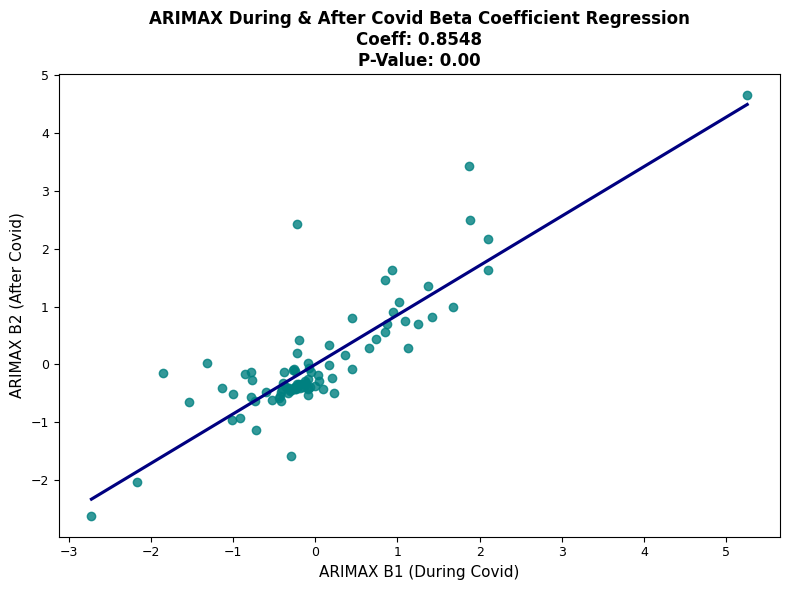

In [ ]:
# Create regression model for 'During Covid Z-Score' as dependent and 'After Covid Z-Score' as independent
model = ols('During_Covid_ZScore ~ After_Covid_ZScore', data=df_output_z).fit()

# Extract formula and p-value, rounded to 2 decimals
formula = f'Coeff: {model.params["After_Covid_ZScore"]:.4f}\nP-Value: {model.pvalues["After_Covid_ZScore"]:.2f}'

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(x='After_Covid_ZScore', y='During_Covid_ZScore', data=df_output_z, ci=None, color='teal', line_kws={'color':'navy'})
plt.title(f'ARIMAX During & After Covid Beta Coefficient Regression\n{formula}', fontsize=12, fontweight='bold')
plt.xlabel('ARIMAX B1 (During Covid)', fontsize=11)
plt.ylabel('ARIMAX B2 (After Covid)', fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

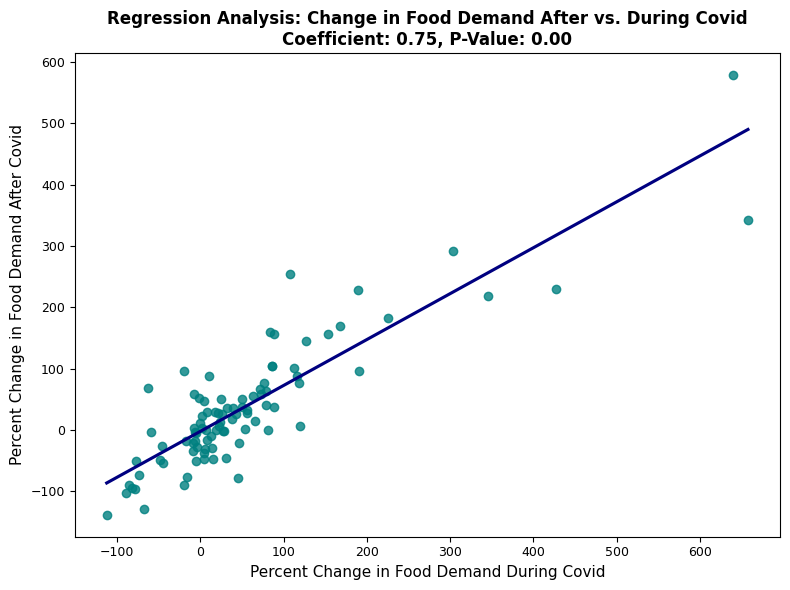

In [ ]:
# Create the regression model
model = ols('Change_In_Food_Demand_After_Covid ~ Change_In_Food_Demand_During_Covid', data=df_output_z_demo).fit()

# Extract the coefficient and p-value, rounded to two decimal places
coeff = model.params['Change_In_Food_Demand_During_Covid']
p_val = model.pvalues['Change_In_Food_Demand_During_Covid']

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(x='Change_In_Food_Demand_During_Covid', y='Change_In_Food_Demand_After_Covid', data=df_output_z_demo, ci=None, color='teal', line_kws={'color':'navy'})
title_text = f'Regression Analysis: Change in Food Demand After vs. During Covid\nCoefficient: {coeff:.2f}, P-Value: {p_val:.2f}'
plt.title(title_text, fontsize=12, fontweight='bold')
plt.xlabel('Percent Change in Food Demand During Covid', fontsize=11)
plt.ylabel('Percent Change in Food Demand After Covid', fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

## Youth Populaton Descriptive Analysis

In [ ]:
df_demo.head()

ZipCode  Population  Veteran_Population      White  \
0   91901       18367            7.214025  82.392334   
1   91902       17759            6.903542  60.189200   
2   91905        1616            3.217822  50.556931   
3   91906        4547            4.860347  67.539037   
4   91910       76291            5.881428  54.003749   

   Black_or_African_American  American_Indian_and_Alaska_Native      Asian  \
0                   1.219579                           1.736811   2.934611   
1                   2.303058                           0.095726  14.285714   
2                   1.175743                          16.460396   0.185644   
3                   2.705080                           6.465802   0.219925   
4                   3.872016                           0.610819   9.829469   

   Native_Hawaiian_and_Other_Pacific_Islander  Other_Race  Two_or_More_Races  \
0                                    0.511787    4.132411           7.072467   
1                                    0.579988    7.027423          15.518892   
2                                    0.309406    3.836634          27.475248   
3                                    0.000000   15.878601           7.191555   
4                                    0.238560   11.741883          19.703504   

   ...  Population_in_Poverty  Population_with_Disability  \
0  ...              12.179452                   10.023412   
1  ...               8.254969                   10.636860   
2  ...              31.497525                   19.678218   
3  ...              37.211348                   11.809985   
4  ...              18.968161                   11.390597   

   Senior_Population_60y  Households_Receiving_SNAP  Median_Income  \
0                    NaN                   1.638809     575.374313   
1                    NaN                   0.732023     632.529985   
2                    NaN                   5.259901       0.000000   
3                    NaN                   3.430834    1081.834176   
4              21.677524                   3.629524     100.935890   

   Youth_Population  Unemployment  Food_Insecurity_Estimate  \
0         21.990526      0.014257                  0.000359   
1         17.619235      0.020507                  0.000353   
2         11.943069      0.228325                  0.009723   
3         33.032769      0.124948                  0.003548   
4         21.702429      0.006281                  0.000132   

   Food_Insecure_Population  LIHEAP_Request  
0                  6.596265       12.408123  
1                  6.276851       15.946844  
2                 15.711696       30.631188  
3                 16.134881        8.357159  
4                 10.069578        7.911811  

[5 rows x 23 columns]

In [ ]:
df_demo['Youth_Population'].describe()

count    107.000000
mean      18.958313
std        8.737844
min        0.000000
25%       15.151907
50%       21.066830
75%       24.096195
max       43.693108
Name: Youth_Population, dtype: float64

In [ ]:
# Creating a new column 'Youth_Population_Category' to classify zip codes
df_demo['Youth_Population_Category'] = pd.qcut(df_demo['Youth_Population'], q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])

# Grouping by 'Youth_Population_Category' and calculating mean for selected columns
grouped_youth_df = df_demo.groupby('Youth_Population_Category').mean()

grouped_youth_df

ZipCode  \
Youth_Population_Category                                                      
Low                        3403922938859070208181646170200534816767849364...   
Medium-Low                 3403811821081266679361161077073694855677095998...   
Medium-High                3534689196507353426045975985938345733167242589...   
High                       3403959968118203695464600047507837521330414955...   

                             Population  Veteran_Population      White  \
Youth_Population_Category                                                
Low                        12789.185185            8.244894  68.924699   
Medium-Low                 29845.777778            7.249812  69.656988   
Medium-High                42979.115385            6.738383  63.771922   
High                       37868.666667            4.974292  61.199272   

                           Black_or_African_American  \
Youth_Population_Category                              
Low                                         7.394607   
Medium-Low                                  3.199502   
Medium-High                                 4.929511   
High                                        3.958310   

                           American_Indian_and_Alaska_Native      Asian  \
Youth_Population_Category                                                 
Low                                                 1.973686   6.322823   
Medium-Low                                          2.485270   9.158875   
Medium-High                                         0.942194   8.376796   
High                                                2.046047  12.164664   

                           Native_Hawaiian_and_Other_Pacific_Islander  \
Youth_Population_Category                                               
Low                                                          0.310080   
Medium-Low                                                   0.392009   
Medium-High                                                  0.445216   
High                                                         0.265168   

                           Other_Race  Two_or_More_Races  ...  \
Youth_Population_Category                                 ...   
Low                          6.179124           8.894981  ...   
Medium-Low                   5.433809           9.673547  ...   
Medium-High                  8.602495          12.931867  ...   
High                         7.881168          12.485372  ...   

                           Population_in_Poverty  Population_with_Disability  \
Youth_Population_Category                                                      
Low                                    13.380600                    7.105486   
Medium-Low                             15.059656                   10.267014   
Medium-High                            17.060069                   10.892130   
High                                   19.536122                    8.505397   

                           Senior_Population_60y  Households_Receiving_SNAP  \
Youth_Population_Category                                                     
Low                                    20.846211                   1.743862   
Medium-Low                             22.948615                   1.742447   
Medium-High                            21.506805                   2.695642   
High                                   18.117970                   3.015816   

                           Median_Income  Youth_Population  Unemployment  \
Youth_Population_Category                                                  
Low                          3365.210764          6.713997      0.088437   
Medium-Low                   1097.955898         18.716832      0.059935   
Medium-High                   492.593618         22.767609      0.012745   
High                         1302.802662         27.775898      0.051567   

                           Food_Insecurity_Estimate  Food_Insecure_Population  \
Youth_Population_Category      

Zipcodes that fall into the 'High' youth population category:
- lowest avg veteran population
- lowest avg white population
- highest avg asian population
- **highest avg population in poverty** -> Low youth population has the lowest population in poverty
- **highest percentage of households receiving SNAP**
- **highest food insecure population** -> could certain zipcodes be less affected by shocks since they already have a greater reliance on community services/food programs?

Note- The categories with the largest overall populations are 'High' and 'Medium-High'


In [ ]:
# sort by youth population to determine zipcodes with highest youth population
df_demo.sort_values(by='Youth_Population', ascending=False)

ZipCode  Population  Veteran_Population      White  \
10    91917         769            0.520156  82.314694   
11    91931         765            0.000000  98.300654   
3     91906        4547            4.860347  67.539037   
8     91915       34616            8.236076  41.547261   
95    92127       50852            4.458035  52.503343   
..      ...         ...                 ...        ...   
69    92093           0                 NaN        NaN   
70    92096           0                 NaN        NaN   
100   92132           0                 NaN        NaN   
110   92161           0                 NaN        NaN   
113   92182           0                 NaN        NaN   

     Black_or_African_American  American_Indian_and_Alaska_Native      Asian  \
10                    1.690507                           1.950585   7.412224   
11                    0.000000                           0.000000   0.000000   
3                     2.705080                           6.465802   0.219925   
8                     8.022302                           0.245551  25.540213   
95                    1.307717                           1.034374  31.530717   
..                         ...                                ...        ...   
69                         NaN                                NaN        NaN   
70                         NaN                                NaN        NaN   
100                        NaN                                NaN        NaN   
110                        NaN                                NaN        NaN   
113                        NaN                                NaN        NaN   

     Native_Hawaiian_and_Other_Pacific_Islander  Other_Race  \
10                                     0.000000    0.650195   
11                                     0.000000    0.000000   
3                                      0.000000   15.878601   
8                                      0.207996    8.854287   
95                                     0.000000    2.090380   
..                                          ...         ...   
69                                          NaN         NaN   
70                                          NaN         NaN   
100                                         NaN         NaN   
110                                         NaN         NaN   
113                                         NaN         NaN   

     Two_or_More_Races  ...  Population_with_Disability  \
10            5.981795  ...                    7.672302   
11            1.699346  ...                    8.235294   
3             7.191555  ...                   11.809985   
8            15.582390  ...                    7.505200   
95           11.533470  ...                    6.395029   
..                 ...  ...                         ...   
69                 NaN  ...                         NaN   
70                 NaN  ...                         NaN   
100                NaN  ...                         NaN   
110                NaN  ...                         NaN   
113                NaN  ...                         NaN   

     Senior_Population_60y  Households_Receiving_SNAP  Median_Income  \
10                     NaN                   4.551365   10739.401821   
11                     NaN                  17.647059    8538.039216   
3                      NaN                   3.430834    1081.834176   
8                      NaN                   1.802635     372.194939   
95               14.685755                   1.248722     307.685047   
..                     ...                        ...            ...   
69                     NaN                        NaN            NaN   
70                     NaN                        NaN            NaN   
100                    NaN                        NaN            NaN   
110                    NaN                        NaN            NaN   
113                    NaN                        NaN            NaN   

     Youth_Popu

In [ ]:
# zipcode 91917 has the highest youth population by quite a bit. Start with exploring other factors for that zipcode


## % Change in food demand analysis

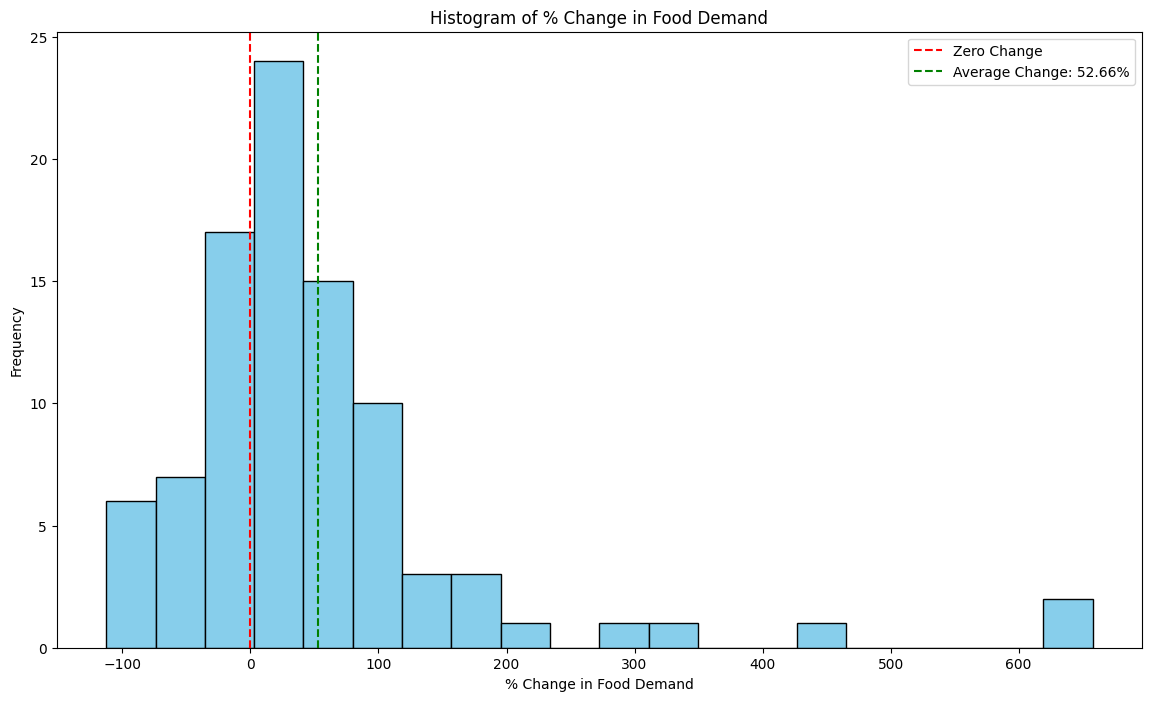

In [ ]:
# Replace non-finite values (like inf or NaN) with NaN and then drop these rows
df_output_z['%_Change_In_Food_Demand'] = df_output_z['%_Change_In_Food_Demand'].replace([np.inf, -np.inf], np.nan)
df_output_z = df_output_z.dropna(subset=['%_Change_In_Food_Demand'])

# Calculate the average change in food demand
average_change = df_output_z['%_Change_In_Food_Demand'].mean()

# Plot the histogram
plt.figure(figsize=(14, 8))
plt.hist(df_output_z['%_Change_In_Food_Demand'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Change')
plt.axvline(x=average_change, color='green', linestyle='--', label=f'Average Change: {average_change:.2f}%')
plt.title('Histogram of % Change in Food Demand')
plt.xlabel('% Change in Food Demand')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Downloading Datasets

In [ ]:
# Specify the folder path where the files will be saved
folder_path = '/content/drive/Shared drives/SD Food Bank Analysis/Model Dataset Export/'

# Save DataFrame to CSV file in the specified folder
#df_output_z.to_csv(f'{folder_path}df_output_z.csv', index=False)
#df_food.to_csv(f'{folder_path}df_food.csv', index=False)
#df_Unemploy_wide.to_csv(f'{folder_path}df_Unemploy_wide.csv', index=False)
#df_demo.to_csv(f'{folder_path}df_demo.csv', index=False)
#regression_demo_df.to_csv(f'{folder_path}regression_demo_df.csv', index=False)
#df_demo_merged.to_csv(f'{folder_path}df_demo_merged.csv', index=False)
#df_demo_averages.to_csv(f'{folder_path}df_demo_averages.csv', index=False)
#percent_regression_demo_df.to_csv(f'{folder_path}percent_regression_demo_df.csv', index=False)
#df_merged.to_csv(f'{folder_path}df_merged.csv', index=False)
rent_food.to_csv(f'{folder_path}rent_food.csv', index=False)